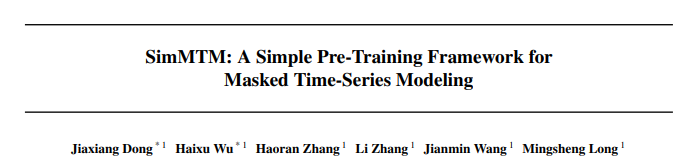


This notebook demonstrate an apllication of SimMTM, a simple self-supervised learning framework for time series modeling. Self-supervised learning is a learning paradigm that allows a model to learn a good representation from the input data itself. The learned representation will be beneficial to some downstream tasks such as forecasting, classification and outlier detection.

Self-supervised learning has a lof of success and achieves state-of-the-art performance in some domains, especially in the image domain. In this demo, we will show a self-supervised learning method, SimMTM, in the time-series domain. SimMTM adopts both masked modeling and contrastive learning to learn a good representation of the input data. By using the learned representation and finetuning it, we achieve a significant improvement compared to the model without self-supervised learning.

In [1]:
if "google.colab" in str(get_ipython()):  # type: ignore # noqa: F821
    %pip install torch==1.13.0

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload


In [3]:
import copy
import os
import urllib.request
from typing import Dict, List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import Tensor, nn
from torch.nn.modules import BatchNorm1d, Dropout, Linear, MultiheadAttention
from torch.utils.data import DataLoader
from tqdm import tqdm

In [4]:
DATA_DIR = "datasets"
TRAIN_FILENAME = "BeijingPM25Quality_TRAIN.ts"
TEST_FILENAME = "BeijingPM25Quality_TEST.ts"

os.makedirs(DATA_DIR, exist_ok=True)

train_url = "https://zenodo.org/record/3902671/files/BeijingPM25Quality_TRAIN.ts?download=1"
test_url = "https://zenodo.org/record/3902671/files/BeijingPM25Quality_TEST.ts?download=1"
urllib.request.urlretrieve(train_url, os.path.join(DATA_DIR, TRAIN_FILENAME))
urllib.request.urlretrieve(test_url, os.path.join(DATA_DIR, TEST_FILENAME))

('datasets/BeijingPM25Quality_TEST.ts',
 <http.client.HTTPMessage at 0x7f92a11e0eb0>)

# Masked Modeling

Self-supervision via a ‘pretext task’ on input data combined with finetuning on labeled data is widely used for improving model performance in language and computer
vision. One of the popular self-supervision tasks on language data is masked modeling. Masking modeling is to mask some of the input entries randomly and predict those masked entries by using unmasked entries. By masked modeling, the model can learn the relationship through different features and different timesteps.

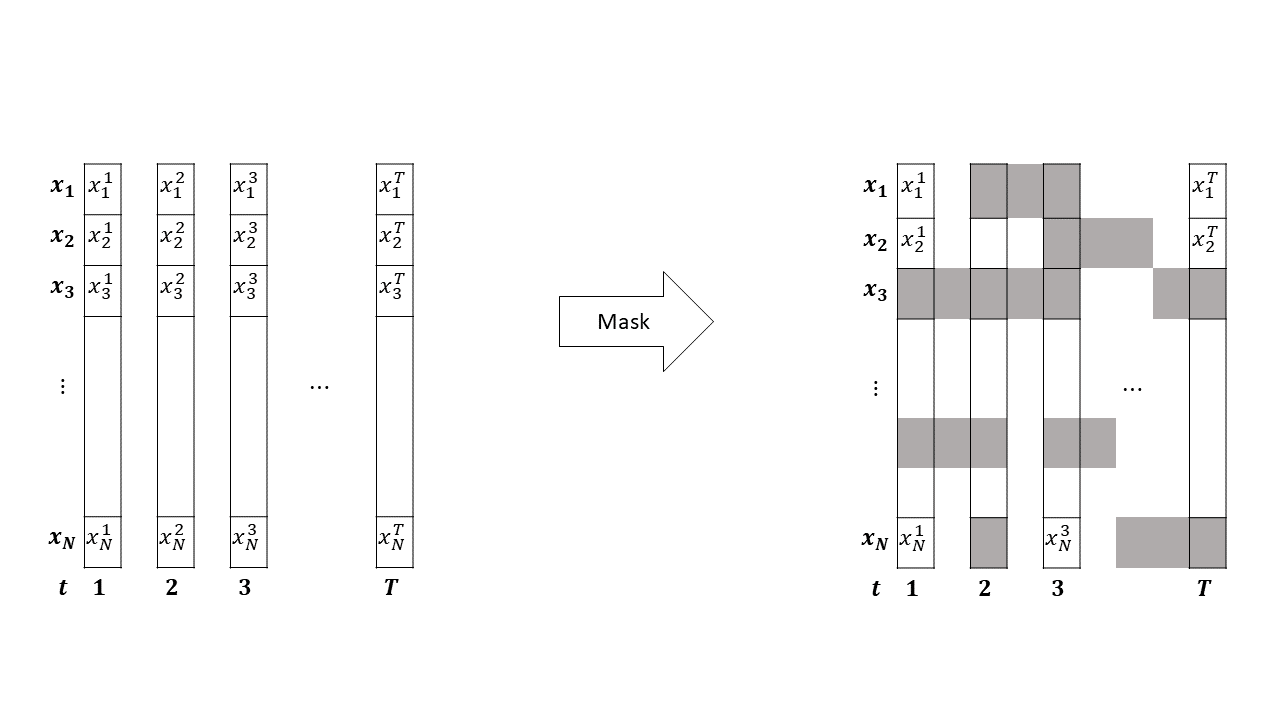

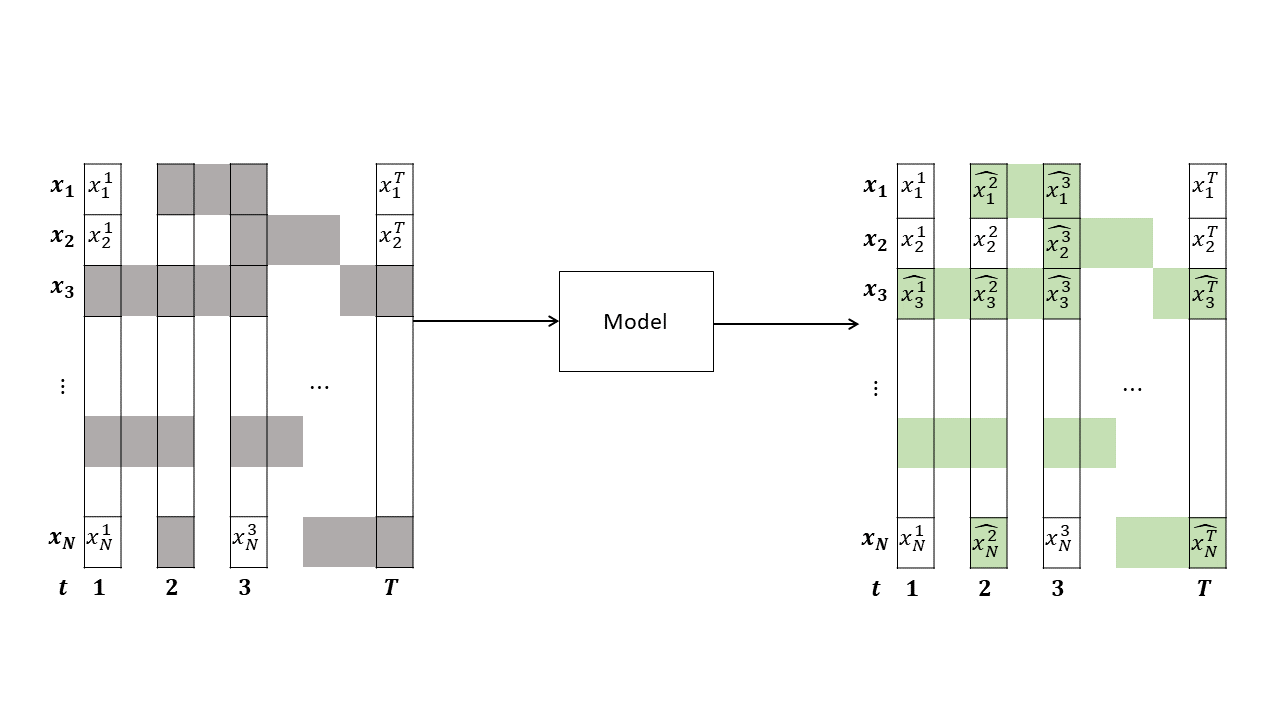

# Masking Choice
### Random Masking

Random Masking is not a good choice to learn a good representation because the model can simply learn to take the average from the neighbour values.



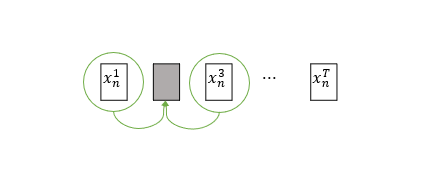

### Geometric Masking

Instead, we choose to use the geometric masking method, which is to mask a sequence of the input data randomly. The length of the sequence is followed by a geometric distribution. In this case, the model requires to recover a masked sequence from other unmasked input data. We suggest the expected length of a masked sequence is a half of the whole time series sequence.

In [5]:
def geom_noise_mask_single(L: int, lm: int, masking_ratio: float) -> np.ndarray:
    """Create geometric noise mask for a single sequence of length L.

    Randomly create a boolean mask of length `L`, consisting of subsequences of
    average length lm, masking with 0s a `masking_ratio` proportion of the sequence L.
    The length of masking subsequences and intervals follow a geometric distribution.

    Parameters
    ----------
    L : int
        Length of mask and sequence to be masked
    lm : int
        Average length of masking subsequences (streaks of 0s)
    masking_ratio : float
        Proportion of L to be masked.

    Return
    ------
    keep_mask : np.ndarray
        Boolean numpy array intended to mask ('drop') with 0s a sequence of length L.
    """
    keep_mask = np.ones(L, dtype=bool)
    p_m = 1 / lm  # probability of each masking sequence stopping. parameter of geometric distribution.
    p_u = (
        p_m * masking_ratio / (1 - masking_ratio)
    )  # probability of each unmasked sequence stopping. parameter of geometric distribution.
    p = [p_m, p_u]

    # Start in state 0 with masking_ratio probability
    state = int(np.random.rand() > masking_ratio)  # state 0 means masking, 1 means not masking
    for i in range(L):
        keep_mask[i] = state  # here it happens that state and masking value corresponding to state are identical
        if np.random.rand() < p[state]:
            state = 1 - state

    return keep_mask

# SimMTM ultilizes both contrastive learning and mask modeling to learn the data representation.
## 1 - Contrastive Learning

when we mask the input time series data, we create many masked views of the input data. We expect that the distance between two views of the same time series sequence is minimized while maximizing the distance between two different sequences.

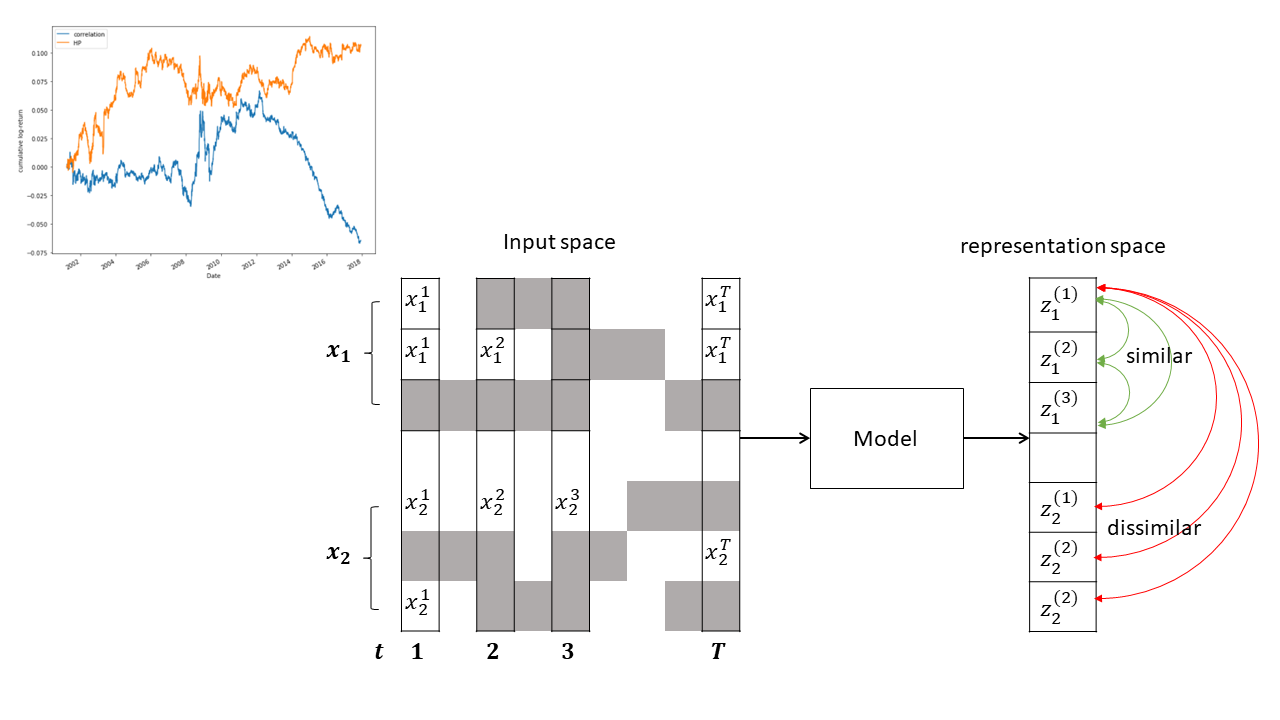

## The contrastive loss is the following: (Eq. 8 in the paper)

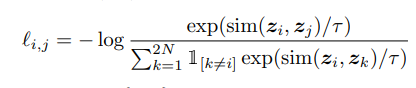

In [6]:
def contrastive_loss(s: Tensor, batch_size: int, tau: float = 0.05) -> Tensor:
    """Compute contrastive loss for a batch of sequences."""
    s = s.squeeze(-1)

    B = s.shape[0]
    v = s.reshape(B, -1)

    norm_v = torch.norm(v, p=2, dim=-1).unsqueeze(-1)
    v = v / norm_v
    u = torch.transpose(v, 0, 1)

    R = torch.matmul(v, u)

    R = torch.exp(R / tau)  # (batch + mask size) x (batch + mask size)

    # number of masks
    M = B // batch_size
    mask = torch.eye(batch_size, device=R.device).repeat_interleave(M, dim=0).repeat_interleave(M, dim=1)

    denom = R * (torch.ones_like(R) - torch.eye(R.shape[0], device=R.device))

    denom = R.sum(-1).unsqueeze(-1)

    loss = torch.log(R / denom)

    loss = (loss * (mask - torch.eye(R.shape[0], device=R.device))).sum(1) / (M - 1)  # except no masked unit
    loss = loss.mean(0)

    return -loss

## 2 - Masked Modeling

SimMTM proposes to recover a time serie by the weighted sum of multiple masked points, which eases the reconstruction task by assembling ruined but complementary temporal variations.

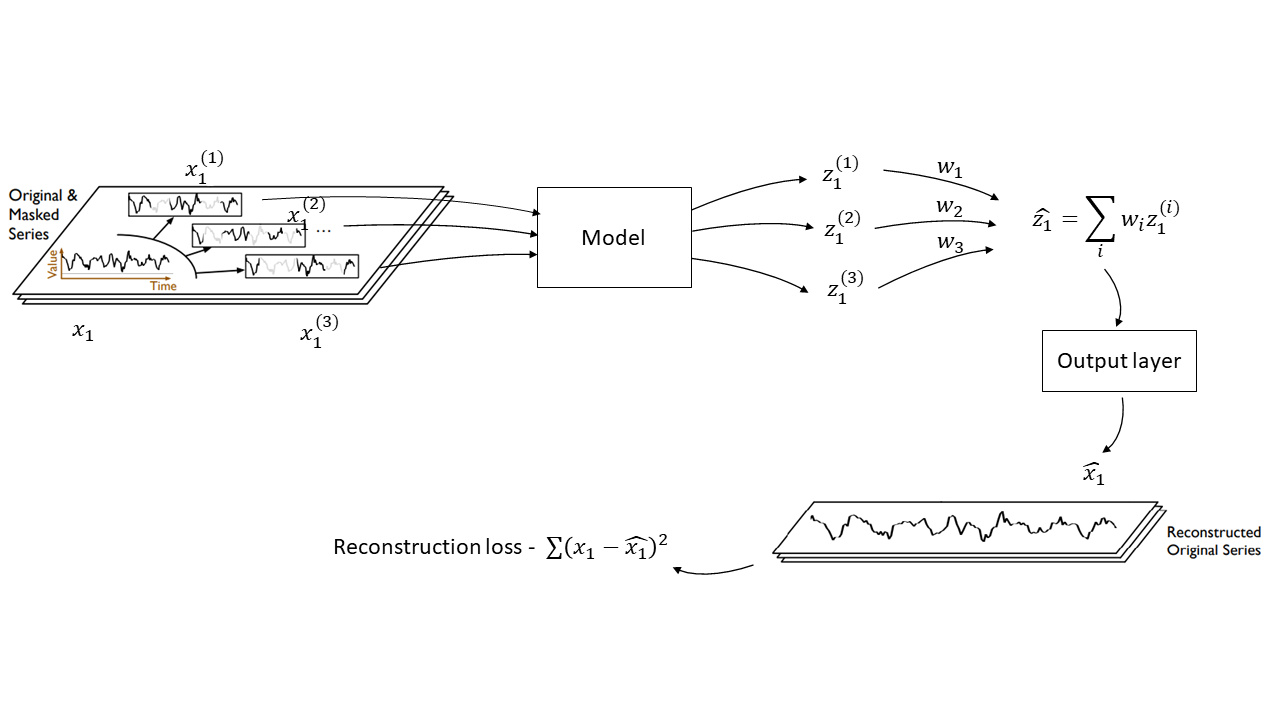

## Model Components

In [7]:
class LearnablePositionalEncoding(nn.Module):
    """Learnable Positional Encoding.

    Parameters
    ----------
    d_model : int
        The embed dim (required).
    dropout : float
        The dropout value (default=0.1).
    max_len : int, optional, default=1024
        The maximum length of the incoming sequence.

    """

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 1024) -> None:
        """Init of LearnablePositionalEncoding."""
        super(LearnablePositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # Each position gets its own embedding
        # Since indices are always 0 ... max_len, we don't have to do a look-up
        self.pe = nn.Parameter(torch.empty(max_len, 1, d_model))  # requires_grad automatically set to True
        nn.init.uniform_(self.pe, -0.02, 0.02)

    def forward(self, x: Tensor) -> Tensor:
        """Forward function of LearnablePositionalEncoding.

        Parameters
        ----------
        x : Tensor
            The sequence fed to the positional encoder model.

        """
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)


class TransformerBatchNormEncoderLayer(nn.modules.Module):
    """Transformer encoder layer block.

    Parameters
    ----------
    d_model : int
        The number of expected features in the input.
    nhead : int
        The number of heads in the multiheadattention models.
    dim_feedforward : int
        The dimension of the feedforward network model.
    dropout : float
        The dropout value (default=0.1).
    """

    def __init__(
        self,
        d_model: int,
        nhead: int,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
    ) -> None:
        """Init of TransformerBatchNormEncoderLayer."""
        super(TransformerBatchNormEncoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = Linear(d_model, dim_feedforward)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model)

        self.norm1 = BatchNorm1d(d_model, eps=1e-5)  # normalizes each feature across batch samples and time steps
        self.norm2 = BatchNorm1d(d_model, eps=1e-5)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

        self.activation = F.gelu

    def __setstate__(self, state: dict) -> None:
        """Set state for batch statistics."""
        if "activation" not in state:
            state["activation"] = F.relu
        super(TransformerBatchNormEncoderLayer, self).__setstate__(state)

    def forward(
        self,
        src: Tensor,
        src_mask: Optional[Tensor] = None,
        src_key_padding_mask: Optional[Tensor] = None,
    ) -> Tensor:
        """Pass the input through the encoder layer.

        Parameters
        ----------
        src : Tensor
            The sequence to the encoder layer (required).
        src_mask : Tensor, optional, default=None
            The mask for the src sequence.
        src_key_padding_mask : Tensor, optional, default=None
            The mask for the src keys per batch.

        """
        src2 = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)  # (seq_len, batch_size, d_model)
        src = src.permute(1, 2, 0)  # (batch_size, d_model, seq_len)
        # src = src.reshape([src.shape[0], -1])  # (batch_size, seq_length * d_model)
        src = self.norm1(src)
        src = src.permute(2, 0, 1)  # restore (seq_len, batch_size, d_model)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)  # (seq_len, batch_size, d_model)
        src = src.permute(1, 2, 0)  # (batch_size, d_model, seq_len)
        src = self.norm2(src)
        src = src.permute(2, 0, 1)  # restore (seq_len, batch_size, d_model)

        return src

## Transformer with SimMTM

In [8]:
class SimMTMTransformerEncoder(nn.Module):
    r"""SimMTM Transformer.

    Parameters
    ----------
    max_len : int
     max input sequence length.
    feat_dim : int
        Input feature dimensions.
    out_len : int
        Output sequence length.
    out_dim : int
        Output feature dimensions.
    d_model : int
        Representation dimensions.
    n_heads : int
        Number of transformer heads.
    num_layers : int
        Number of transformer layers.
    dim_feedforward : int
        Hidden layer dimensions.
    dropout : float
        Dropout rate.
    temporal_unit : int
        Default number of masked views.
    """

    def __init__(
        self,
        max_len: int,
        feat_dim: int,
        out_len: int,
        out_dim: int,
        d_model: int = 16,
        n_heads: int = 4,
        num_layers: int = 2,
        dim_feedforward: int = 32,
        dropout: float = 0.2,
        temporal_unit: int = 3,
    ) -> None:
        """Init of SimMTMTransformerEncoder."""
        super(SimMTMTransformerEncoder, self).__init__()

        self.max_len = max_len
        self.d_model = d_model
        self.n_heads = n_heads

        self.tau = 0.05
        self.mask_length = max_len // 2
        self.mask_rate = 0.5

        self.project_inp = nn.Linear(feat_dim, d_model)
        self.projector_layer = nn.Linear(max_len, 1)
        self.pos_enc1 = LearnablePositionalEncoding(d_model, dropout=dropout, max_len=max_len)
        self.pos_enc2 = LearnablePositionalEncoding(d_model, dropout=dropout, max_len=out_len)

        self.act = F.gelu

        # encoder_layer = nn.TransformerEncoderLayer(
        #   d_model, self.n_heads, dim_feedforward, dropout
        # )
        encoder_layer = TransformerBatchNormEncoderLayer(d_model, self.n_heads, dim_feedforward, dropout)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.output_layer = nn.Linear(d_model, feat_dim)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout1d(dropout)

        # self.predict_layer1 = nn.Conv1d(d_model, 512, 5, stride=1)
        self.predict_layer1 = nn.Linear(max_len, out_len)
        self.predict_layer2 = nn.Linear(d_model, out_dim)
        # self.bn = nn.BatchNorm1d(d_model)

        self.feat_dim = feat_dim

        self.temporal_unit = temporal_unit

        self.w1 = torch.nn.parameter.Parameter(data=torch.ones(1), requires_grad=True)
        self.w2 = torch.nn.parameter.Parameter(data=torch.ones(1), requires_grad=True)

    def forward(self, X: Tensor, N: Optional[int] = None) -> Tuple[Tensor, Tensor]:
        """Reconstruct the input and create the projected output of X.

        Parameters
        ----------
        X : Tensor
            (batch_size, seq_length, feat_dim) torch tensor of original input
        N : int, optional, default=None
            Number of masked views.

        Return
        ------
        output
            (batch_size, seq_length, feat_dim) torch tensor of reconstructed input.
        _s
            (batch_size, d_model, 1) torch tensor of similarity scores.
        """
        _x = X

        # Create masked views of the input X
        if N is None:
            N = self.temporal_unit
        for _i in range(N):
            mask = geom_noise_mask_single(X.shape[0] * X.shape[1] * X.shape[2], self.mask_length, self.mask_rate)
            mask = mask.reshape(X.shape[0], X.shape[1], X.shape[2])
            mask = torch.from_numpy(mask).to(X.device)
            x_masked = mask * X
            _x = torch.cat([_x, x_masked], axis=-1)  # [batch_size, seq_length, feat_dim * temporal_unit]

        _x = _x.reshape(X.shape[0] * (N + 1), X.shape[1], X.shape[2])

        inp = _x.permute(1, 0, 2)
        inp = self.project_inp(inp) * np.sqrt(
            self.d_model
        )  # [seq_length, batch_size, d_model] project input vectors to d_model dimensional space
        inp = self.pos_enc1(inp)  # add positional encoding

        output = self.transformer_encoder(inp)  # (seq_length, batch_size, d_model)
        output = self.act(output)  # the output transformer encoder/decoder embeddings don't include non-linearity
        output = output.permute(1, 0, 2)  # (batch_size, seq_length, d_model)
        output = self.dropout1(output)

        z_hat, _s = self.project(output, self.tau, N)
        # Most probably defining a Linear(d_model,feat_dim) vectorizes the operation over (seq_length, batch_size).
        output = self.output_layer(z_hat)  # (batch_size, seq_length, feat_dim)

        return output, _s

    def project(self, z: Tensor, tau: float, N: int) -> Tuple[Tensor, Tensor]:
        """Output a weighted average of z.

        Parameters
        ----------
        z : Tensor
            (batch_size, seq_length, feat_dim) torch tensor of encoded representations.
        tau : float
            Temperature of similarity matrix.
        N : int
            Number of masked views.

        Returns
        -------
        z_hat : Tensor
            (batch_size, seq_length, d_model) torch tensor of weighted average of z.
        s : Tensor
            (batch_size, d_model, 1) torch tensor of similarity scores.
        """
        _z = z.transpose(1, 2)  # [batch_size, d_model, seq_length]
        _s = s = self.projector_layer(_z)  # [batch_size, d_model, 1]

        if self.training:
            mask = torch.ones(1, self.d_model, 1).to(z.device)
            mask = self.dropout3(mask)
            s = s * mask
            s = s + torch.randn(s.shape).to(z.device) * 1e-2

        s = s.squeeze(-1)
        B = s.shape[0]
        v = s.reshape(B, -1)

        norm_v = torch.norm(v, p=2, dim=-1).unsqueeze(-1)
        v = v / norm_v
        u = torch.transpose(v, 0, 1)

        R = torch.matmul(v, u)

        R = torch.exp(R / tau)  # (batch + mask size) x (batch + mask size)
        R = R * (
            torch.ones_like(R) - torch.eye(R.shape[0], device=R.device)
        )  # zero out the weight of no masked component
        R = R / R.sum(-1).unsqueeze(-1)
        M = N + 1
        R = R[::M]  # extract every no mask unit # (batch size) x (batch + mask size)

        z_hat = (R.unsqueeze(-1).unsqueeze(-1).detach() * z.unsqueeze(0)).sum(1)
        return z_hat, _s

    def predict(self, X: Tensor) -> Tensor:
        """Predict an output given X.

        Parameters
        ----------
        X : Tensor
            (batch_size, seq_length, feat_dim) torch tensor of original input.

        Return
        ------
        output : Tensor
            (batch_size, out_seq_len, out_dim) torch tensor of predicted output.
        """
        # permute because pytorch convention for transformers is
        # [seq_length, batch_size, feat_dim]. padding_masks [batch_size, feat_dim]
        inp = X.permute(1, 0, 2)
        inp = self.project_inp(inp) * np.sqrt(
            self.d_model
        )  # [seq_length, batch_size, d_model] project input vectors to d_model dimensional space
        inp = self.pos_enc1(inp)  # add positional encoding
        # NOTE: logic for padding masks is reversed to comply with definition in
        # MultiHeadAttention, TransformerEncoderLayer

        output = self.transformer_encoder(inp)
        output = output.permute(1, 0, 2)  # (batch_size, seq_length, d_model)
        # output = self.dropout1(output)

        output = output.transpose(1, 2)  # (batch_size, d_model, seq_length)
        output = self.predict_layer1(output)
        # output = self.act(output)

        output = output.transpose(1, 2)  # (batch_size, seq_length, d_model)
        output = output.permute(1, 0, 2)
        output = self.pos_enc2(output)
        output = output.permute(1, 0, 2)
        output = self.dropout2(output)
        output = self.predict_layer2(output)

        return output

# Data Loading and Preparation

In this demo, we use a benchmask time series dataset called BeijingPM25Quality.
This dataset is part of the Monash, UEA & UCR time series regression repository. http://tseregression.org/

The goal of this dataset is to predict PM2.5 air quality in the city of Beijing. This dataset contains 17532 time series with 9 dimensions.  This includes hourly air pollutants measurments (SO2, NO2, CO and O3), temperature, pressure, dew point, rainfall and windspeed measurments from 12 nationally controlled air quality monitoring sites. The air-quality data are from the Beijing Municipal Environmental Monitoring Center. The meteorological data in each air-quality site are matched with the nearest weather station from the China Meteorological Administration. The time period is from March 1st, 2013 to February 28th, 2017.

In [9]:
class TsFileParseException(Exception):
    """Should be raised when parsing a .ts file and the format is incorrect."""

    pass


def load_from_tsfile_to_dataframe(  # noqa: C901
    full_file_path_and_name: str,
    return_separate_X_and_y: bool = True,
    replace_missing_vals_with: str = "NaN",
) -> Union[Tuple[pd.DataFrame, np.ndarray], pd.DataFrame]:
    """Load data from a .ts file into a Pandas DataFrame.

    Parameters
    ----------
    full_file_path_and_name: str
        The full pathname of the .ts file to read.
    return_separate_X_and_y: bool
        true if X and Y values should be returned as separate Data Frames (X) and a numpy array (y), false otherwise.
        This is only relevant for data that
    replace_missing_vals_with: str
       The value that missing values in the text file should be replaced with prior to parsing.

    Returns
    -------
    DataFrame, ndarray
        If return_separate_X_and_y then a tuple containing a DataFrame and a numpy
        array containing the relevant time-series and corresponding class values.
    DataFrame
        If not return_separate_X_and_y then a single DataFrame containing all
        time-series and (if relevant) a column "class_vals" the associated class values.
    """
    # Initialize flags and variables used when parsing the file
    metadata_started = False
    data_started = False

    has_problem_name_tag = False
    has_timestamps_tag = False
    has_univariate_tag = False
    has_class_labels_tag = False
    has_target_labels_tag = False
    has_data_tag = False

    previous_timestamp_was_float = None
    previous_timestamp_was_int = None
    previous_timestamp_was_timestamp = None
    num_dimensions = None
    is_first_case = True
    instance_list = []  # type: ignore
    class_val_list = []  # type: ignore
    line_num = 0

    # Parse the file
    # print(full_file_path_and_name)
    with open(full_file_path_and_name, "r", encoding="utf-8") as file:
        for line in tqdm(file):
            # print(".", end='')
            # Strip white space from start/end of line and change to lowercase for use below
            line = line.strip().lower()
            # Empty lines are valid at any point in a file
            if line:
                # Check if this line contains metadata
                # NOTE: Even though metadata is stored in this
                # function it is not currently published externally
                if line.startswith("@problemname"):
                    # Check that the data has not started
                    if data_started:
                        raise TsFileParseException("metadata must come before data")
                    # Check that the associated value is valid
                    tokens = line.split(" ")
                    token_len = len(tokens)

                    if token_len == 1:
                        raise TsFileParseException("problemname tag requires an associated value")

                    line[len("@problemname") + 1 :]
                    has_problem_name_tag = True
                    metadata_started = True
                elif line.startswith("@timestamps"):
                    # Check that the data has not started
                    if data_started:
                        raise TsFileParseException("metadata must come before data")

                    # Check that the associated value is valid
                    tokens = line.split(" ")
                    token_len = len(tokens)

                    if token_len != 2:
                        raise TsFileParseException("timestamps tag requires an associated Boolean value")
                    elif tokens[1] == "true":
                        timestamps = True
                    elif tokens[1] == "false":
                        timestamps = False
                    else:
                        raise TsFileParseException("invalid timestamps value")
                    has_timestamps_tag = True
                    metadata_started = True
                elif line.startswith("@univariate"):
                    # Check that the data has not started
                    if data_started:
                        raise TsFileParseException("metadata must come before data")

                    # Check that the associated value is valid
                    tokens = line.split(" ")
                    token_len = len(tokens)
                    if token_len != 2:
                        raise TsFileParseException("univariate tag requires an associated Boolean value")
                    elif tokens[1] == "true":
                        pass
                    elif tokens[1] == "false":
                        pass
                    else:
                        raise TsFileParseException("invalid univariate value")

                    has_univariate_tag = True
                    metadata_started = True
                elif line.startswith("@classlabel"):
                    # Check that the data has not started
                    if data_started:
                        raise TsFileParseException("metadata must come before data")

                    # Check that the associated value is valid
                    tokens = line.split(" ")
                    token_len = len(tokens)

                    if token_len == 1:
                        raise TsFileParseException("classlabel tag requires an associated Boolean value")

                    if tokens[1] == "true":
                        class_labels = True
                    elif tokens[1] == "false":
                        class_labels = False
                    else:
                        raise TsFileParseException("invalid classLabel value")

                    # Check if we have any associated class values
                    if token_len == 2 and class_labels:
                        raise TsFileParseException("if the classlabel tag is true then class values must be supplied")

                    has_class_labels_tag = True
                    [token.strip() for token in tokens[2:]]
                    metadata_started = True
                elif line.startswith("@targetlabel"):
                    # Check that the data has not started
                    if data_started:
                        raise TsFileParseException("metadata must come before data")

                    # Check that the associated value is valid
                    tokens = line.split(" ")
                    token_len = len(tokens)

                    if token_len == 1:
                        raise TsFileParseException("targetlabel tag requires an associated Boolean value")

                    if tokens[1] == "true":
                        target_labels = True
                    elif tokens[1] == "false":
                        target_labels = False
                    else:
                        raise TsFileParseException("invalid targetLabel value")

                    has_target_labels_tag = True
                    class_val_list = []
                    metadata_started = True
                # Check if this line contains the start of data
                elif line.startswith("@data"):
                    if line != "@data":
                        raise TsFileParseException("data tag should not have an associated value")

                    if data_started and not metadata_started:
                        raise TsFileParseException("metadata must come before data")
                    else:
                        has_data_tag = True
                        data_started = True
                # If the 'data tag has been found then metadata has been parsed and data can be loaded
                elif data_started:
                    # Check that a full set of metadata has been provided
                    incomplete_regression_meta_data = (
                        not has_problem_name_tag
                        or not has_timestamps_tag
                        or not has_univariate_tag
                        or not has_target_labels_tag
                        or not has_data_tag
                    )
                    incomplete_classification_meta_data = (
                        not has_problem_name_tag
                        or not has_timestamps_tag
                        or not has_univariate_tag
                        or not has_class_labels_tag
                        or not has_data_tag
                    )
                    if incomplete_regression_meta_data and incomplete_classification_meta_data:
                        raise TsFileParseException("a full set of metadata has not been provided before the data")

                    # Replace any missing values with the value specified
                    line = line.replace("?", replace_missing_vals_with)

                    # Check if we dealing with data that has timestamps
                    if timestamps:
                        # We're dealing with timestamps so cannot just split line on ':' as timestamps may contain one
                        has_another_value = False
                        has_another_dimension = False

                        timestamps_for_dimension = []  # type: ignore
                        values_for_dimension = []  # type: ignore

                        this_line_num_dimensions = 0
                        line_len = len(line)
                        char_num = 0

                        while char_num < line_len:
                            # Move through any spaces
                            while char_num < line_len and str.isspace(line[char_num]):
                                char_num += 1

                            # See if there is any more data to read in or if we should validate that read thus far

                            if char_num < line_len:
                                # See if we have an empty dimension (i.e. no values)
                                if line[char_num] == ":":
                                    if len(instance_list) < (this_line_num_dimensions + 1):
                                        instance_list.append([])

                                    instance_list[this_line_num_dimensions].append(pd.Series())
                                    this_line_num_dimensions += 1

                                    has_another_value = False
                                    has_another_dimension = True

                                    timestamps_for_dimension = []
                                    values_for_dimension = []

                                    char_num += 1
                                else:
                                    # Check if we have reached a class label
                                    if line[char_num] != "(" and target_labels:
                                        class_val = line[char_num:].strip()

                                        # if class_val not in class_val_list:
                                        #     raise TsFileParseException(
                                        #         "the class value '" + class_val + "' on line " + str(
                                        #             line_num + 1) + " is not valid")

                                        class_val_list.append(float(class_val))
                                        char_num = line_len

                                        has_another_value = False
                                        has_another_dimension = False

                                        timestamps_for_dimension = []
                                        values_for_dimension = []

                                    else:
                                        # Read in the data contained within the next tuple

                                        if line[char_num] != "(" and not target_labels:
                                            raise TsFileParseException(
                                                "dimension "
                                                + str(this_line_num_dimensions + 1)
                                                + " on line "
                                                + str(line_num + 1)
                                                + " does not start with a '('"
                                            )

                                        char_num += 1
                                        tuple_data = ""

                                        while char_num < line_len and line[char_num] != ")":
                                            tuple_data += line[char_num]
                                            char_num += 1

                                        if char_num >= line_len or line[char_num] != ")":
                                            raise TsFileParseException(
                                                "dimension "
                                                + str(this_line_num_dimensions + 1)
                                                + " on line "
                                                + str(line_num + 1)
                                                + " does not end with a ')'"
                                            )

                                        # Read in any spaces immediately after the current tuple

                                        char_num += 1

                                        while char_num < line_len and str.isspace(line[char_num]):
                                            char_num += 1

                                        # Check if there is another value or dimension to process after this tuple

                                        if char_num >= line_len:
                                            has_another_value = False
                                            has_another_dimension = False

                                        elif line[char_num] == ",":
                                            has_another_value = True
                                            has_another_dimension = False

                                        elif line[char_num] == ":":
                                            has_another_value = False
                                            has_another_dimension = True

                                        char_num += 1

                                        # Get the numeric value for the tuple by
                                        # reading from the end of the tuple data
                                        # backwards to the last comma

                                        last_comma_index = tuple_data.rfind(",")

                                        if last_comma_index == -1:
                                            raise TsFileParseException(
                                                "dimension "
                                                + str(this_line_num_dimensions + 1)
                                                + " on line "
                                                + str(line_num + 1)
                                                + " contains a tuple that has no comma inside of it"
                                            )

                                        try:
                                            value = tuple_data[last_comma_index + 1 :]
                                            value = float(value)  # type: ignore

                                        except ValueError:
                                            raise TsFileParseException(
                                                "dimension "
                                                + str(this_line_num_dimensions + 1)
                                                + " on line "
                                                + str(line_num + 1)
                                                + " contains a tuple that does not have a valid numeric value"
                                            )

                                        # Check the type of timestamp that we have

                                        timestamp = tuple_data[0:last_comma_index]

                                        try:
                                            timestamp = int(timestamp)  # type: ignore
                                            timestamp_is_int = True
                                            timestamp_is_timestamp = False
                                        except ValueError:
                                            timestamp_is_int = False

                                        if not timestamp_is_int:
                                            try:
                                                timestamp = float(timestamp)  # type: ignore
                                                timestamp_is_float = True
                                                timestamp_is_timestamp = False
                                            except ValueError:
                                                timestamp_is_float = False

                                        if not timestamp_is_int and not timestamp_is_float:
                                            try:
                                                timestamp = timestamp.strip()
                                                timestamp_is_timestamp = True
                                            except ValueError:
                                                timestamp_is_timestamp = False

                                        # Make sure that the timestamps in the file
                                        # (not just this dimension or case) are consistent

                                        if (
                                            not timestamp_is_timestamp
                                            and not timestamp_is_int
                                            and not timestamp_is_float
                                        ):
                                            raise TsFileParseException(
                                                "dimension "
                                                + str(this_line_num_dimensions + 1)
                                                + " on line "
                                                + str(line_num + 1)
                                                + " contains a tuple that has an invalid timestamp '"
                                                + timestamp
                                                + "'"
                                            )

                                        if (
                                            previous_timestamp_was_float is not None
                                            and previous_timestamp_was_float
                                            and not timestamp_is_float
                                        ):
                                            raise TsFileParseException(
                                                "dimension "
                                                + str(this_line_num_dimensions + 1)
                                                + " on line "
                                                + str(line_num + 1)
                                                + " contains tuples where the timestamp format is inconsistent"
                                            )

                                        if (
                                            previous_timestamp_was_int is not None
                                            and previous_timestamp_was_int
                                            and not timestamp_is_int
                                        ):
                                            raise TsFileParseException(
                                                "dimension "
                                                + str(this_line_num_dimensions + 1)
                                                + " on line "
                                                + str(line_num + 1)
                                                + " contains tuples where the timestamp format is inconsistent"
                                            )

                                        if (
                                            previous_timestamp_was_timestamp is not None
                                            and previous_timestamp_was_timestamp
                                            and not timestamp_is_timestamp
                                        ):
                                            raise TsFileParseException(
                                                "dimension "
                                                + str(this_line_num_dimensions + 1)
                                                + " on line "
                                                + str(line_num + 1)
                                                + " contains tuples where the timestamp format is inconsistent"
                                            )

                                        # Store the values

                                        timestamps_for_dimension += [timestamp]
                                        values_for_dimension += [value]

                                        #  If this was our first tuple then we store the type of timestamp we had

                                        if previous_timestamp_was_timestamp is None and timestamp_is_timestamp:
                                            previous_timestamp_was_timestamp = True
                                            previous_timestamp_was_int = False
                                            previous_timestamp_was_float = False

                                        if previous_timestamp_was_int is None and timestamp_is_int:
                                            previous_timestamp_was_timestamp = False
                                            previous_timestamp_was_int = True
                                            previous_timestamp_was_float = False

                                        if previous_timestamp_was_float is None and timestamp_is_float:
                                            previous_timestamp_was_timestamp = False
                                            previous_timestamp_was_int = False
                                            previous_timestamp_was_float = True

                                        # See if we should add the data for this dimension

                                        if not has_another_value:
                                            if len(instance_list) < (this_line_num_dimensions + 1):
                                                instance_list.append([])

                                            if timestamp_is_timestamp:
                                                timestamps_for_dimension = pd.DatetimeIndex(timestamps_for_dimension)

                                            instance_list[this_line_num_dimensions].append(
                                                pd.Series(
                                                    index=timestamps_for_dimension,
                                                    data=values_for_dimension,
                                                )
                                            )
                                            this_line_num_dimensions += 1

                                            timestamps_for_dimension = []
                                            values_for_dimension = []

                            elif has_another_value:
                                raise TsFileParseException(
                                    "dimension "
                                    + str(this_line_num_dimensions + 1)
                                    + " on line "
                                    + str(line_num + 1)
                                    + " ends with a ',' that is not followed by another tuple"
                                )

                            elif has_another_dimension and target_labels:
                                raise TsFileParseException(
                                    "dimension "
                                    + str(this_line_num_dimensions + 1)
                                    + " on line "
                                    + str(line_num + 1)
                                    + " ends with a ':' while it should list a class value"
                                )

                            elif has_another_dimension and not target_labels:
                                if len(instance_list) < (this_line_num_dimensions + 1):
                                    instance_list.append([])

                                instance_list[this_line_num_dimensions].append(pd.Series(dtype=np.float32))
                                this_line_num_dimensions += 1
                                num_dimensions = this_line_num_dimensions

                            # If this is the 1st line of data we have seen then note the dimensions

                            if not has_another_value and not has_another_dimension:
                                if num_dimensions is None:
                                    num_dimensions = this_line_num_dimensions

                                if num_dimensions != this_line_num_dimensions:
                                    raise TsFileParseException(
                                        "line "
                                        + str(line_num + 1)
                                        + " does not have the same number of dimensions as the previous line of data"
                                    )

                        # Check that we are not expecting some more data, and if not, store that processed above

                        if has_another_value:
                            raise TsFileParseException(
                                "dimension "
                                + str(this_line_num_dimensions + 1)
                                + " on line "
                                + str(line_num + 1)
                                + " ends with a ',' that is not followed by another tuple"
                            )

                        elif has_another_dimension and target_labels:
                            raise TsFileParseException(
                                "dimension "
                                + str(this_line_num_dimensions + 1)
                                + " on line "
                                + str(line_num + 1)
                                + " ends with a ':' while it should list a class value"
                            )

                        elif has_another_dimension and not target_labels:
                            if len(instance_list) < (this_line_num_dimensions + 1):
                                instance_list.append([])

                            instance_list[this_line_num_dimensions].append(pd.Series())
                            this_line_num_dimensions += 1
                            num_dimensions = this_line_num_dimensions

                        # If this is the 1st line of data we have seen then note the dimensions

                        if not has_another_value and num_dimensions != this_line_num_dimensions:
                            raise TsFileParseException(
                                "line "
                                + str(line_num + 1)
                                + " does not have the same number of dimensions as the previous line of data"
                            )

                        # Check if we should have class values, and if so that
                        # they are contained in those listed in the metadata

                        if target_labels and len(class_val_list) == 0:
                            raise TsFileParseException("the cases have no associated class values")
                    else:
                        dimensions = line.split(":")
                        # If first row then note the number of dimensions (that must be the same for all cases)
                        if is_first_case:
                            num_dimensions = len(dimensions)

                            if target_labels:
                                num_dimensions -= 1

                            for dim in range(0, num_dimensions):
                                instance_list.append([])
                            is_first_case = False

                        # See how many dimensions the case whose data is represented in this line has
                        this_line_num_dimensions = len(dimensions)

                        if target_labels:
                            this_line_num_dimensions -= 1

                        # All dimensions should be included for all series, even if they are empty
                        if this_line_num_dimensions != num_dimensions:
                            raise TsFileParseException(
                                "inconsistent number of dimensions. Expecting "
                                + str(num_dimensions)
                                + " but have read "
                                + str(this_line_num_dimensions)
                            )

                        # Process the data for each dimension
                        for dim in range(0, num_dimensions):  # type: ignore
                            dimension = dimensions[dim].strip()

                            if dimension:
                                data_series = dimension.split(",")
                                data_series = [float(i) for i in data_series]
                                instance_list[dim].append(pd.Series(data_series))
                            else:
                                instance_list[dim].append(pd.Series())

                        if target_labels:
                            class_val_list.append(float(dimensions[num_dimensions].strip()))

            line_num += 1

    # Check that the file is not empty
    if line_num:
        # Check that the file contains both metadata and data
        complete_regression_meta_data = (
            has_problem_name_tag
            and has_timestamps_tag
            and has_univariate_tag
            and has_target_labels_tag
            and has_data_tag
        )
        complete_classification_meta_data = (
            has_problem_name_tag
            and has_timestamps_tag
            and has_univariate_tag
            and has_class_labels_tag
            and has_data_tag
        )

        if metadata_started and not complete_regression_meta_data and not complete_classification_meta_data:
            raise TsFileParseException("metadata incomplete")
        elif metadata_started and not data_started:
            raise TsFileParseException("file contained metadata but no data")
        elif metadata_started and data_started and len(instance_list) == 0:
            raise TsFileParseException("file contained metadata but no data")

        # Create a DataFrame from the data parsed above
        data = pd.DataFrame(dtype=np.float32)

        for dim in range(0, num_dimensions):  # type: ignore
            data["dim_" + str(dim)] = instance_list[dim]

        # Check if we should return any associated class labels separately

        if target_labels:
            if return_separate_X_and_y:
                return data, np.asarray(class_val_list)
            else:
                data["class_vals"] = pd.Series(class_val_list)
                return data
        else:
            return data
    else:
        raise TsFileParseException("empty file")

In [10]:
data, _ = load_from_tsfile_to_dataframe(os.path.join(DATA_DIR, TRAIN_FILENAME))
test_data, _ = load_from_tsfile_to_dataframe(os.path.join(DATA_DIR, TEST_FILENAME))

11942it [00:45, 260.88it/s]
5072it [00:18, 269.57it/s]


In [11]:
data  # noqa: B018

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8
0,2013-03-01 00:00:00 4.0 2013-03-01 01:00:0...,2013-03-01 00:00:00 7.0 2013-03-01 01:00:0...,2013-03-01 00:00:00 300.0 2013-03-01 01:00:...,2013-03-01 00:00:00 77.0 2013-03-01 01:00:0...,2013-03-01 00:00:00 -0.7 2013-03-01 01:00:00...,2013-03-01 00:00:00 1023.0 2013-03-01 01:00...,2013-03-01 00:00:00 -18.8 2013-03-01 01:00:0...,2013-03-01 00:00:00 0.0 2013-03-01 01:00:00...,2013-03-01 00:00:00 4.4 2013-03-01 01:00:00...
1,2013-03-02 00:00:00 24.0 2013-03-02 01:00:0...,2013-03-02 00:00:00 44.0 2013-03-02 01:00:...,2013-03-02 00:00:00 500.0 2013-03-02 01:00...,2013-03-02 00:00:00 44.0 2013-03-02 01:00:0...,2013-03-02 00:00:00 -0.4 2013-03-02 01:00:00...,2013-03-02 00:00:00 1031.0 2013-03-02 01:00...,2013-03-02 00:00:00 -17.6 2013-03-02 01:00:0...,2013-03-02 00:00:00 0.0 2013-03-02 01:00:00...,2013-03-02 00:00:00 1.4 2013-03-02 01:00:00...
2,2013-03-03 00:00:00 73.0 2013-03-03 01:00:...,2013-03-03 00:00:00 100.0 2013-03-03 01:00:...,2013-03-03 00:00:00 1899.0 2013-03-03 01:00...,2013-03-03 00:00:00 2.0 2013-03-03 01:00:0...,2013-03-03 00:00:00 -1.4 2013-03-03 01:00:0...,2013-03-03 00:00:00 1020.4 2013-03-03 01:00...,2013-03-03 00:00:00 -13.0 2013-03-03 01:00:0...,2013-03-03 00:00:00 0.0 2013-03-03 01:00:00...,2013-03-03 00:00:00 1.2 2013-03-03 01:00:00...
3,2013-03-04 00:00:00 51.0 2013-03-04 01:00:0...,2013-03-04 00:00:00 86.0 2013-03-04 01:00:0...,2013-03-04 00:00:00 1300.0 2013-03-04 01:00...,2013-03-04 00:00:00 4.0 2013-03-04 01:00:0...,2013-03-04 00:00:00 7.7 2013-03-04 01:00:0...,2013-03-04 00:00:00 1015.7 2013-03-04 01:00...,2013-03-04 00:00:00 -11.1 2013-03-04 01:00:0...,2013-03-04 00:00:00 0.0 2013-03-04 01:00:00...,2013-03-04 00:00:00 2.6 2013-03-04 01:00:00...
4,2013-03-05 00:00:00 66.0 2013-03-05 01:00:...,2013-03-05 00:00:00 78.0 2013-03-05 01:00:...,2013-03-05 00:00:00 1100.0 2013-03-05 01:00...,2013-03-05 00:00:00 84.0 2013-03-05 01:00:0...,2013-03-05 00:00:00 4.7 2013-03-05 01:00:0...,2013-03-05 00:00:00 1015.2 2013-03-05 01:00...,2013-03-05 00:00:00 -9.1 2013-03-05 01:00:00...,2013-03-05 00:00:00 0.0 2013-03-05 01:00:00...,2013-03-05 00:00:00 1.6 2013-03-05 01:00:00...
...,...,...,...,...,...,...,...,...,...
11913,2015-12-27 00:00:00 16.0 2015-12-27 01:00:0...,2015-12-27 00:00:00 39.0 2015-12-27 01:00:0...,2015-12-27 00:00:00 800.0 2015-12-27 01:00...,2015-12-27 00:00:00 25.0 2015-12-27 01:00:0...,2015-12-27 00:00:00 -4.1 2015-12-27 01:00:00...,2015-12-27 00:00:00 1033.5 2015-12-27 01:00...,2015-12-27 00:00:00 -10.7 2015-12-27 01:00:0...,2015-12-27 00:00:00 0.0 2015-12-27 01:00:00...,2015-12-27 00:00:00 2.4 2015-12-27 01:00:00...
11914,2015-12-28 00:00:00 26.0 2015-12-28 01:00:0...,2015-12-28 00:00:00 66.0 2015-12-28 01:00:...,2015-12-28 00:00:00 2600.0 2015-12-28 01:00...,2015-12-28 00:00:00 11.0 2015-12-28 01:00:0...,2015-12-28 00:00:00 -7.6 2015-12-28 01:00:00...,2015-12-28 00:00:00 1033.2 2015-12-28 01:00...,2015-12-28 00:00:00 -11.4 2015-12-28 01:00:0...,2015-12-28 00:00:00 0.0 2015-12-28 01:00:00...,2015-12-28 00:00:00 0.9 2015-12-28 01:00:00...
11915,2015-12-29 00:00:00 33.0 2015-12-29 01:00:0...,2015-12-29 00:00:00 105.0 2015-12-29 01:00:...,2015-12-29 00:00:00 3500.0 2015-12-29 01:00...,2015-12-29 00:00:00 9.0 2015-12-29 01:00:0...,2015-12-29 00:00:00 -3.2 2015-12-29 01:00:00...,2015-12-29 00:00:00 1028.2 2015-12-29 01:00...,2015-12-29 00:00:00 -6.5 2015-12-29 01:00:00...,2015-12-29 00:00:00 0.0 2015-12-29 01:00:00...,2015-12-29 00:00:00 1.0 2015-12-29 01:00:00...
11916,2015-12-30 00:00:00 38.0 2015-12-30 01:00:0...,2015-12-30 00:00:00 148.0 2015-12-30 01:00:...,2015-12-30 00:00:00 6500.0 2015-12-30 01:00...,2015-12-30 00:00:00 10.0 2015-12-30 01:00:0...,2015-12-30 00:00:00 -2.9 2015-12-30 01:00:00...,2015-12-30 00:00:00 1023.9 2015-12-30 01:00...,2015-12-30 00:00:00 -4.3 2015-12-30 01:00:0...,2015-12-30 00:00:00 0.0 2015-12-30 01:00:00...,2015-12-30 00:00:00 1.4 2015-12-30 01:00:00...


In [12]:
def interpolate_missing(y: pd.Series) -> pd.Series:
    """Replace NaN values in pd.Series `y` using linear interpolation."""
    if y.isna().any():
        y = y.interpolate(method="linear", limit_direction="both")
    return y


def subsample(y: pd.Series, limit: int = 256, factor: int = 2) -> pd.Series:
    """Return subsampled sequence by the specified integer factor if a given Series is longer than `limit`."""
    if len(y) > limit:
        return y[::factor].reset_index(drop=True)
    return y


def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """Preprocess dataframe."""
    lengths = df.applymap(
        lambda x: len(x)
    ).values  # (num_samples, num_dimensions) array containing the length of each series
    horiz_diffs = np.abs(lengths - np.expand_dims(lengths[:, 0], -1))

    # most general check: len(np.unique(lengths.values)) > 1:  # returns array of unique lengths of sequences
    if np.sum(horiz_diffs) > 0:  # if any row (sample) has varying length across dimensions
        # logger.warning("Not all time series dimensions have same length - will
        # attempt to fix by subsampling first dimension...")
        df = df.applymap(subsample)  # TODO: this addresses a very specific case (PPGDalia)

    lengths = df.applymap(lambda x: len(x)).values
    vert_diffs = np.abs(lengths - np.expand_dims(lengths[0, :], 0))
    if np.sum(vert_diffs) > 0:  # if any column (dimension) has varying length across samples
        int(np.max(lengths[:, 0]))
        # logger.warning("Not all samples have same length: maximum length set to {}".format(self.max_seq_len))
    else:
        lengths[0, 0]

    # First create a (seq_len, feat_dim) dataframe for each sample, indexed by a single integer ("ID" of the sample)
    # Then concatenate into a (num_samples * seq_len, feat_dim) dataframe, with multiple rows corresponding to the
    # sample index (i.e. the same scheme as all datasets in this project)
    df = pd.concat(
        (
            pd.DataFrame({col: df.loc[row, col] for col in df.columns})
            .reset_index(drop=True)
            .set_index(pd.Series(lengths[row, 0] * [row]))
            for row in range(df.shape[0])
        ),
        axis=0,
    )

    # Replace NaN values
    grp = df.groupby(by=df.index)
    df = grp.transform(interpolate_missing)

    return df

In [13]:
data = preprocess_data(data)
test_data = preprocess_data(test_data)

In [14]:
# Standard Normalization
normalizer = StandardScaler()
data[:] = normalizer.fit_transform(data)
test_data[:] = normalizer.transform(test_data)

In [15]:
data  # noqa: B018

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8
0,-0.578723,-1.262339,-0.827454,0.331285,-1.354746,1.282597,-1.671897,-0.077887,2.197101
0,-0.578723,-1.262339,-0.827454,0.331285,-1.390913,1.302251,-1.626944,-0.077887,2.439034
0,-0.536462,-1.177416,-0.827454,0.261866,-1.390913,1.331731,-1.626944,-0.077887,3.164833
0,-0.282896,-1.149109,-0.827454,0.244512,-1.418038,1.430000,-1.716850,-0.077887,1.148725
0,-0.240636,-1.120801,-0.827454,0.244512,-1.472287,1.498788,-1.724342,-0.077887,0.261637
...,...,...,...,...,...,...,...,...,...
11917,0.393278,1.257031,1.802584,-0.848838,-1.418038,1.606883,-0.907691,-0.077887,-0.544806
11917,0.689105,1.341954,2.153256,-0.848838,-1.517495,1.597057,-0.892707,-0.077887,-0.302873
11917,0.562322,1.228724,1.627248,-0.848838,-1.535578,1.557749,-0.862738,-0.077887,-0.625450
11917,0.942670,1.341954,2.591596,-0.779419,-1.607911,1.528269,-0.832769,-0.077887,-1.028672


In [16]:
max_len = 24
out_size = 6
out_dim = 9

model = SimMTMTransformerEncoder(
    max_len=18,
    feat_dim=data.shape[1],
    out_len=out_size,
    out_dim=out_dim,
    d_model=64,
    n_heads=4,
    num_layers=1,
    dim_feedforward=64,
)

device = "cuda"
model.to(device)
model.tau = 0.05

model.mask_length = max_len // 2
model.mask_ratio = 0.5
model.mask_views = 3

model.contrastive_views = 2
init_model = copy.deepcopy(model)

In [17]:
optimizer_finetune = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [18]:
batch_size = 64

train_indices, val_indices = train_test_split(np.array(data.index.unique()), test_size=0.2)
test_indices = np.array(test_data.index.unique())

train_dataloader = DataLoader(train_indices, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_indices, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_indices, batch_size=batch_size, shuffle=True)

print(
    train_indices.shape,
    val_indices.shape,
    test_indices.shape,
    np.array(data.index.unique()).shape,
)

(9534,) (2384,) (5048,) (11918,)


# Self-Supervised Learning Training Loop

In [19]:
i: int = 0
max_epoch: int = 50
best_loss: float = 1.0e10
best_epoch: int = 0
device = "cuda"
loss_fn = nn.MSELoss()
best_model = copy.deepcopy(model)


while i < max_epoch:
    train_loss: Dict[str, List[float]] = {"loss": [], "loss_mse": [], "loss_con": []}
    progress_bar = tqdm(train_dataloader)

    for IDs in progress_bar:
        model.train()
        X = torch.tensor(data.loc[IDs].to_numpy()).to(device)
        X = X.float()

        X = X.reshape(-1, max_len, X.shape[-1])
        X = X[:, :18, :]

        #         _X = []
        #         idx = torch.randint(low=0, high=6, size=(X.shape[0],))
        #         for j in range(18):
        #             _X.append(X[torch.arange(X.shape[0]),idx+j,:].unsqueeze(1))

        #         X = torch.cat(_X,dim=1)

        # X = X[:, :, -1:]

        pred, _ = model(X, 3)  # (batch_size, padded_length, feat_dim)

        loss_mse = loss_fn(pred, X)

        _, s = model(X, 1)  # (batch_size, padded_length, feat_dim)
        loss_con = contrastive_loss(s, X.shape[0])

        loss = 0.1 * loss_mse + loss_con

        optimizer_finetune.zero_grad()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
        optimizer_finetune.step()

        progress_bar.set_description(
            "Epoch {0} - Training loss: {1:.2f} - MSE loss: {2:.2f} - Contrastive loss: {3:.2f}".format(
                i,
                loss.cpu().detach().numpy().item(),
                loss_mse.cpu().detach().numpy().item(),
                loss_con.cpu().detach().numpy().item(),
            )
        )
        train_loss["loss"].append(loss.item())
        train_loss["loss_mse"].append(loss_mse.item())
        train_loss["loss_con"].append(loss_con.item())

    with torch.no_grad():
        val_loss: Dict[str, List[float]] = {"loss": [], "loss_mse": [], "loss_con": []}
        for IDs in val_dataloader:
            model.eval()
            X = torch.tensor(data.loc[IDs].to_numpy()).to(device)
            X = X.float()
            X = X.reshape(-1, max_len, X.shape[-1])
            X = X[:, :18, :]
            # X = X[:, :, -1:]

            #             _X = []
            #             idx = torch.randint(low=0, high=6, size=(X.shape[0],))
            #             for j in range(18):
            #                 _X.append(X[torch.arange(X.shape[0]),idx+j,:].unsqueeze(1))

            #             X = torch.cat(_X,dim=1)

            # X = X[:, :, -1:]

            pred, _ = model(X, 3)  # (batch_size, padded_length, feat_dim)

            loss_mse = loss_fn(pred, X)

            _, s = model(X, 1)  # (batch_size, padded_length, feat_dim)
            loss_con = contrastive_loss(s, X.shape[0])

            loss = 0.1 * loss_mse + loss_con

            val_loss["loss"].append(loss.item())
            val_loss["loss_mse"].append(loss_mse.item())
            val_loss["loss_con"].append(loss_con.item())

        if torch.tensor(val_loss["loss"]).mean().item() < best_loss:
            best_loss = torch.tensor(val_loss["loss"]).mean()
            best_model = copy.deepcopy(model)
            best_epoch = i

        progress_bar.write(
            "Epoch {0} - Training loss: {1:.2f} {2:.2f} {3:.2f} - Validation loss: {4:.2f} {5:.2f} {6:.2f}".format(
                i,
                torch.tensor(train_loss["loss"]).mean().item(),
                torch.tensor(train_loss["loss_mse"]).mean().item(),
                torch.tensor(train_loss["loss_con"]).mean().item(),
                torch.tensor(val_loss["loss"]).mean().item(),
                torch.tensor(val_loss["loss_mse"]).mean().item(),
                torch.tensor(val_loss["loss_con"]).mean().item(),
            )
        )
    i += 1


tqdm.write("Best Epoch {} - Best Validation loss: {}".format(best_epoch, best_loss))

Epoch 0 - Training loss: 2.98 - MSE loss: 0.74 - Contrastive loss: 2.91: 100%|██████████| 149/149 [00:12<00:00, 11.95it/s] 


Epoch 0 - Training loss: 5.82 0.72 5.75 - Validation loss: 2.58 0.59 2.52


Epoch 1 - Training loss: 2.46 - MSE loss: 0.60 - Contrastive loss: 2.40: 100%|██████████| 149/149 [00:10<00:00, 13.66it/s]


Epoch 1 - Training loss: 2.74 0.55 2.68 - Validation loss: 2.23 0.51 2.18


Epoch 2 - Training loss: 2.33 - MSE loss: 0.61 - Contrastive loss: 2.27: 100%|██████████| 149/149 [00:10<00:00, 13.68it/s]


Epoch 2 - Training loss: 2.47 0.51 2.42 - Validation loss: 2.04 0.49 1.99


Epoch 3 - Training loss: 2.35 - MSE loss: 0.42 - Contrastive loss: 2.31: 100%|██████████| 149/149 [00:11<00:00, 13.53it/s]


Epoch 3 - Training loss: 2.31 0.50 2.26 - Validation loss: 1.88 0.47 1.83


Epoch 4 - Training loss: 2.07 - MSE loss: 0.44 - Contrastive loss: 2.02: 100%|██████████| 149/149 [00:10<00:00, 13.68it/s]


Epoch 4 - Training loss: 2.20 0.50 2.15 - Validation loss: 1.74 0.46 1.70


Epoch 5 - Training loss: 1.99 - MSE loss: 0.41 - Contrastive loss: 1.95: 100%|██████████| 149/149 [00:10<00:00, 13.63it/s]


Epoch 5 - Training loss: 2.12 0.50 2.07 - Validation loss: 1.70 0.46 1.65


Epoch 6 - Training loss: 2.04 - MSE loss: 0.65 - Contrastive loss: 1.98: 100%|██████████| 149/149 [00:11<00:00, 13.54it/s]


Epoch 6 - Training loss: 2.07 0.49 2.02 - Validation loss: 1.62 0.45 1.58


Epoch 7 - Training loss: 1.91 - MSE loss: 0.44 - Contrastive loss: 1.87: 100%|██████████| 149/149 [00:10<00:00, 13.56it/s]


Epoch 7 - Training loss: 2.01 0.49 1.96 - Validation loss: 1.59 0.45 1.54


Epoch 8 - Training loss: 2.13 - MSE loss: 0.38 - Contrastive loss: 2.09: 100%|██████████| 149/149 [00:10<00:00, 13.63it/s]


Epoch 8 - Training loss: 1.98 0.49 1.93 - Validation loss: 1.56 0.46 1.51


Epoch 9 - Training loss: 1.86 - MSE loss: 0.49 - Contrastive loss: 1.81: 100%|██████████| 149/149 [00:10<00:00, 14.02it/s]


Epoch 9 - Training loss: 1.94 0.49 1.89 - Validation loss: 1.54 0.45 1.49


Epoch 10 - Training loss: 1.95 - MSE loss: 0.45 - Contrastive loss: 1.91: 100%|██████████| 149/149 [00:11<00:00, 13.44it/s]


Epoch 10 - Training loss: 1.93 0.49 1.88 - Validation loss: 1.51 0.45 1.47


Epoch 11 - Training loss: 1.96 - MSE loss: 1.14 - Contrastive loss: 1.84: 100%|██████████| 149/149 [00:10<00:00, 13.75it/s]


Epoch 11 - Training loss: 1.89 0.49 1.84 - Validation loss: 1.50 0.44 1.45


Epoch 12 - Training loss: 1.96 - MSE loss: 0.41 - Contrastive loss: 1.92: 100%|██████████| 149/149 [00:10<00:00, 14.01it/s]


Epoch 12 - Training loss: 1.87 0.48 1.82 - Validation loss: 1.48 0.44 1.44


Epoch 13 - Training loss: 1.84 - MSE loss: 0.37 - Contrastive loss: 1.80: 100%|██████████| 149/149 [00:11<00:00, 13.22it/s]


Epoch 13 - Training loss: 1.86 0.48 1.81 - Validation loss: 1.47 0.44 1.42


Epoch 14 - Training loss: 1.77 - MSE loss: 0.40 - Contrastive loss: 1.73: 100%|██████████| 149/149 [00:11<00:00, 13.40it/s]


Epoch 14 - Training loss: 1.84 0.48 1.79 - Validation loss: 1.45 0.44 1.41


Epoch 15 - Training loss: 1.64 - MSE loss: 0.41 - Contrastive loss: 1.60: 100%|██████████| 149/149 [00:10<00:00, 13.71it/s]


Epoch 15 - Training loss: 1.82 0.48 1.77 - Validation loss: 1.44 0.45 1.40


Epoch 16 - Training loss: 1.88 - MSE loss: 0.38 - Contrastive loss: 1.85: 100%|██████████| 149/149 [00:10<00:00, 13.57it/s]


Epoch 16 - Training loss: 1.81 0.48 1.77 - Validation loss: 1.45 0.45 1.41


Epoch 17 - Training loss: 1.76 - MSE loss: 0.49 - Contrastive loss: 1.71: 100%|██████████| 149/149 [00:11<00:00, 13.52it/s]


Epoch 17 - Training loss: 1.80 0.48 1.76 - Validation loss: 1.44 0.44 1.39


Epoch 18 - Training loss: 1.86 - MSE loss: 0.50 - Contrastive loss: 1.81: 100%|██████████| 149/149 [00:11<00:00, 13.49it/s]


Epoch 18 - Training loss: 1.79 0.48 1.74 - Validation loss: 1.41 0.44 1.36


Epoch 19 - Training loss: 1.89 - MSE loss: 0.49 - Contrastive loss: 1.84: 100%|██████████| 149/149 [00:10<00:00, 13.60it/s]


Epoch 19 - Training loss: 1.78 0.48 1.73 - Validation loss: 1.43 0.44 1.39


Epoch 20 - Training loss: 1.70 - MSE loss: 0.43 - Contrastive loss: 1.66: 100%|██████████| 149/149 [00:10<00:00, 13.77it/s]


Epoch 20 - Training loss: 1.78 0.48 1.74 - Validation loss: 1.41 0.44 1.37


Epoch 21 - Training loss: 1.71 - MSE loss: 0.58 - Contrastive loss: 1.65: 100%|██████████| 149/149 [00:10<00:00, 13.71it/s]


Epoch 21 - Training loss: 1.77 0.48 1.72 - Validation loss: 1.40 0.44 1.36


Epoch 22 - Training loss: 1.62 - MSE loss: 0.45 - Contrastive loss: 1.58: 100%|██████████| 149/149 [00:10<00:00, 13.55it/s]


Epoch 22 - Training loss: 1.76 0.48 1.71 - Validation loss: 1.42 0.44 1.37


Epoch 23 - Training loss: 1.83 - MSE loss: 0.57 - Contrastive loss: 1.78: 100%|██████████| 149/149 [00:11<00:00, 13.44it/s]


Epoch 23 - Training loss: 1.75 0.48 1.71 - Validation loss: 1.39 0.44 1.35


Epoch 24 - Training loss: 1.74 - MSE loss: 0.42 - Contrastive loss: 1.70: 100%|██████████| 149/149 [00:11<00:00, 13.40it/s]


Epoch 24 - Training loss: 1.74 0.48 1.70 - Validation loss: 1.39 0.43 1.34


Epoch 25 - Training loss: 1.72 - MSE loss: 0.52 - Contrastive loss: 1.67: 100%|██████████| 149/149 [00:11<00:00, 13.31it/s]


Epoch 25 - Training loss: 1.75 0.48 1.71 - Validation loss: 1.39 0.44 1.35


Epoch 26 - Training loss: 1.85 - MSE loss: 0.52 - Contrastive loss: 1.80: 100%|██████████| 149/149 [00:11<00:00, 13.44it/s]


Epoch 26 - Training loss: 1.74 0.48 1.69 - Validation loss: 1.39 0.43 1.35


Epoch 27 - Training loss: 1.78 - MSE loss: 0.37 - Contrastive loss: 1.75: 100%|██████████| 149/149 [00:11<00:00, 13.48it/s]


Epoch 27 - Training loss: 1.73 0.48 1.68 - Validation loss: 1.39 0.44 1.34


Epoch 28 - Training loss: 1.57 - MSE loss: 0.88 - Contrastive loss: 1.48: 100%|██████████| 149/149 [00:10<00:00, 13.59it/s]


Epoch 28 - Training loss: 1.72 0.48 1.67 - Validation loss: 1.38 0.43 1.34


Epoch 29 - Training loss: 1.72 - MSE loss: 0.38 - Contrastive loss: 1.68: 100%|██████████| 149/149 [00:11<00:00, 13.37it/s]


Epoch 29 - Training loss: 1.73 0.48 1.68 - Validation loss: 1.36 0.43 1.31


Epoch 30 - Training loss: 1.75 - MSE loss: 0.51 - Contrastive loss: 1.70: 100%|██████████| 149/149 [00:10<00:00, 13.87it/s]


Epoch 30 - Training loss: 1.73 0.48 1.68 - Validation loss: 1.37 0.43 1.33


Epoch 31 - Training loss: 1.68 - MSE loss: 0.39 - Contrastive loss: 1.64: 100%|██████████| 149/149 [00:10<00:00, 13.93it/s]


Epoch 31 - Training loss: 1.72 0.48 1.67 - Validation loss: 1.36 0.43 1.32


Epoch 32 - Training loss: 1.81 - MSE loss: 0.43 - Contrastive loss: 1.77: 100%|██████████| 149/149 [00:11<00:00, 13.20it/s]


Epoch 32 - Training loss: 1.71 0.48 1.66 - Validation loss: 1.37 0.43 1.33


Epoch 33 - Training loss: 1.67 - MSE loss: 0.44 - Contrastive loss: 1.63: 100%|██████████| 149/149 [00:11<00:00, 13.47it/s]


Epoch 33 - Training loss: 1.71 0.48 1.66 - Validation loss: 1.36 0.44 1.32


Epoch 34 - Training loss: 1.68 - MSE loss: 0.38 - Contrastive loss: 1.64: 100%|██████████| 149/149 [00:10<00:00, 13.78it/s]


Epoch 34 - Training loss: 1.71 0.48 1.66 - Validation loss: 1.36 0.44 1.32


Epoch 35 - Training loss: 1.65 - MSE loss: 0.46 - Contrastive loss: 1.60: 100%|██████████| 149/149 [00:10<00:00, 14.06it/s]


Epoch 35 - Training loss: 1.70 0.48 1.66 - Validation loss: 1.37 0.44 1.33


Epoch 36 - Training loss: 1.67 - MSE loss: 0.54 - Contrastive loss: 1.62: 100%|██████████| 149/149 [00:10<00:00, 13.98it/s]


Epoch 36 - Training loss: 1.70 0.48 1.65 - Validation loss: 1.36 0.43 1.31


Epoch 37 - Training loss: 1.71 - MSE loss: 0.50 - Contrastive loss: 1.66: 100%|██████████| 149/149 [00:10<00:00, 13.74it/s]


Epoch 37 - Training loss: 1.70 0.48 1.66 - Validation loss: 1.35 0.43 1.30


Epoch 38 - Training loss: 1.69 - MSE loss: 0.47 - Contrastive loss: 1.64: 100%|██████████| 149/149 [00:10<00:00, 13.98it/s]


Epoch 38 - Training loss: 1.69 0.48 1.65 - Validation loss: 1.36 0.43 1.31


Epoch 39 - Training loss: 1.73 - MSE loss: 0.43 - Contrastive loss: 1.69: 100%|██████████| 149/149 [00:10<00:00, 13.92it/s]


Epoch 39 - Training loss: 1.70 0.48 1.65 - Validation loss: 1.36 0.44 1.32


Epoch 40 - Training loss: 1.69 - MSE loss: 0.50 - Contrastive loss: 1.64: 100%|██████████| 149/149 [00:10<00:00, 13.81it/s]


Epoch 40 - Training loss: 1.69 0.48 1.64 - Validation loss: 1.36 0.43 1.32


Epoch 41 - Training loss: 1.53 - MSE loss: 0.68 - Contrastive loss: 1.47: 100%|██████████| 149/149 [00:10<00:00, 13.95it/s]


Epoch 41 - Training loss: 1.69 0.48 1.64 - Validation loss: 1.35 0.43 1.31


Epoch 42 - Training loss: 1.78 - MSE loss: 0.52 - Contrastive loss: 1.72: 100%|██████████| 149/149 [00:10<00:00, 13.60it/s]


Epoch 42 - Training loss: 1.69 0.48 1.64 - Validation loss: 1.35 0.44 1.31


Epoch 43 - Training loss: 1.76 - MSE loss: 0.72 - Contrastive loss: 1.69: 100%|██████████| 149/149 [00:10<00:00, 13.74it/s]


Epoch 43 - Training loss: 1.68 0.48 1.63 - Validation loss: 1.35 0.43 1.31


Epoch 44 - Training loss: 1.52 - MSE loss: 0.41 - Contrastive loss: 1.48: 100%|██████████| 149/149 [00:10<00:00, 14.02it/s]


Epoch 44 - Training loss: 1.69 0.48 1.64 - Validation loss: 1.35 0.43 1.31


Epoch 45 - Training loss: 1.62 - MSE loss: 0.43 - Contrastive loss: 1.57: 100%|██████████| 149/149 [00:10<00:00, 14.44it/s]


Epoch 45 - Training loss: 1.69 0.48 1.64 - Validation loss: 1.35 0.44 1.31


Epoch 46 - Training loss: 1.74 - MSE loss: 0.47 - Contrastive loss: 1.69: 100%|██████████| 149/149 [00:10<00:00, 14.14it/s]


Epoch 46 - Training loss: 1.68 0.48 1.63 - Validation loss: 1.35 0.43 1.30


Epoch 47 - Training loss: 1.68 - MSE loss: 0.43 - Contrastive loss: 1.64: 100%|██████████| 149/149 [00:10<00:00, 13.96it/s]


Epoch 47 - Training loss: 1.68 0.48 1.63 - Validation loss: 1.35 0.44 1.31


Epoch 48 - Training loss: 1.60 - MSE loss: 0.40 - Contrastive loss: 1.56: 100%|██████████| 149/149 [00:10<00:00, 13.80it/s]


Epoch 48 - Training loss: 1.68 0.48 1.63 - Validation loss: 1.34 0.44 1.29


Epoch 49 - Training loss: 1.69 - MSE loss: 0.48 - Contrastive loss: 1.64: 100%|██████████| 149/149 [00:10<00:00, 13.73it/s]


Epoch 49 - Training loss: 1.68 0.48 1.63 - Validation loss: 1.34 0.43 1.30
Best Epoch 48 - Best Validation loss: 1.3371572494506836


# Finetune Training Loop



In [20]:
finetune_model = copy.deepcopy(best_model)
optimizer = torch.optim.AdamW(finetune_model.parameters(), lr=1e-3)

batch_size = 64
train_dataloader = DataLoader(train_indices, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_indices, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_indices, batch_size=batch_size, shuffle=True)

In [21]:
i = 0
max_epoch = 50
best_loss = 1.0e10
best_finetune_model = copy.deepcopy(best_model)
best_epoch = 0
device = "cuda"
finetune_model.to(device)
while i < max_epoch:
    ft_train_loss = []
    progress_bar = tqdm(train_dataloader)

    for IDs in progress_bar:
        finetune_model.train()

        X = torch.tensor(data.loc[IDs].to_numpy()).to(device)
        X = X.float().reshape(-1, max_len, X.shape[-1])
        targets = X[:, 18:24, :]
        X = X[:, :18, :]

        pred = finetune_model.predict(X)
        pred = pred.reshape(X.shape[0], out_size, -1)
        loss = loss_fn(pred, targets)

        optimizer.zero_grad()
        loss.backward()

        nn.utils.clip_grad_norm_(finetune_model.parameters(), max_norm=4.0)
        optimizer.step()

        progress_bar.set_description("Epoch {} - Training loss: {:.2f}".format(i, loss))
        ft_train_loss.append(loss.item())

    with torch.no_grad():
        ft_val_loss = []
        for IDs in val_dataloader:
            finetune_model.eval()

            X = torch.tensor(data.loc[IDs].to_numpy()).to(device)
            X = X.float().reshape(-1, max_len, X.shape[-1])
            targets = X[:, 18:24, :]
            X = X[:, :18, :]

            pred = finetune_model.predict(X.float())
            pred = pred.reshape(X.shape[0], out_size, -1)
            loss = loss_fn(pred, targets)

            ft_val_loss.append(loss.item())

        if torch.tensor(ft_val_loss).mean().item() < best_loss:
            best_loss = torch.tensor(ft_val_loss).mean().item()
            best_finetune_model = copy.deepcopy(finetune_model)
            best_epoch = i

    progress_bar.write(
        "Epoch {} - Training loss: {:.2f} - Validation loss: {:.2f}".format(
            i,
            torch.tensor(ft_train_loss).mean().item(),
            torch.tensor(ft_val_loss).mean().item(),
        )
    )
    i += 1


tqdm.write("Best Epoch {} - Best Validation loss: {}".format(best_epoch, best_loss))

Epoch 0 - Training loss: 0.40: 100%|██████████| 149/149 [00:05<00:00, 25.37it/s]


Epoch 0 - Training loss: 0.87 - Validation loss: 0.50


Epoch 1 - Training loss: 0.26: 100%|██████████| 149/149 [00:05<00:00, 25.08it/s]


Epoch 1 - Training loss: 0.54 - Validation loss: 0.41


Epoch 2 - Training loss: 0.46: 100%|██████████| 149/149 [00:05<00:00, 25.63it/s]


Epoch 2 - Training loss: 0.50 - Validation loss: 0.39


Epoch 3 - Training loss: 0.32: 100%|██████████| 149/149 [00:05<00:00, 25.52it/s]


Epoch 3 - Training loss: 0.48 - Validation loss: 0.39


Epoch 4 - Training loss: 0.39: 100%|██████████| 149/149 [00:06<00:00, 24.62it/s]


Epoch 4 - Training loss: 0.47 - Validation loss: 0.37


Epoch 5 - Training loss: 0.76: 100%|██████████| 149/149 [00:05<00:00, 24.94it/s]


Epoch 5 - Training loss: 0.47 - Validation loss: 0.37


Epoch 6 - Training loss: 0.29: 100%|██████████| 149/149 [00:05<00:00, 25.13it/s]


Epoch 6 - Training loss: 0.46 - Validation loss: 0.37


Epoch 7 - Training loss: 0.24: 100%|██████████| 149/149 [00:05<00:00, 25.39it/s]


Epoch 7 - Training loss: 0.45 - Validation loss: 0.36


Epoch 8 - Training loss: 0.36: 100%|██████████| 149/149 [00:05<00:00, 26.35it/s]


Epoch 8 - Training loss: 0.45 - Validation loss: 0.37


Epoch 9 - Training loss: 0.22: 100%|██████████| 149/149 [00:05<00:00, 25.17it/s]


Epoch 9 - Training loss: 0.45 - Validation loss: 0.36


Epoch 10 - Training loss: 0.36: 100%|██████████| 149/149 [00:05<00:00, 25.38it/s]


Epoch 10 - Training loss: 0.45 - Validation loss: 0.36


Epoch 11 - Training loss: 0.32: 100%|██████████| 149/149 [00:05<00:00, 25.41it/s]


Epoch 11 - Training loss: 0.45 - Validation loss: 0.36


Epoch 12 - Training loss: 0.23: 100%|██████████| 149/149 [00:05<00:00, 25.65it/s]


Epoch 12 - Training loss: 0.44 - Validation loss: 0.36


Epoch 13 - Training loss: 0.61: 100%|██████████| 149/149 [00:05<00:00, 25.13it/s]


Epoch 13 - Training loss: 0.45 - Validation loss: 0.35


Epoch 14 - Training loss: 0.46: 100%|██████████| 149/149 [00:05<00:00, 25.83it/s]


Epoch 14 - Training loss: 0.44 - Validation loss: 0.38


Epoch 15 - Training loss: 0.25: 100%|██████████| 149/149 [00:05<00:00, 25.81it/s]


Epoch 15 - Training loss: 0.44 - Validation loss: 0.35


Epoch 16 - Training loss: 0.51: 100%|██████████| 149/149 [00:05<00:00, 25.73it/s]


Epoch 16 - Training loss: 0.44 - Validation loss: 0.35


Epoch 17 - Training loss: 0.35: 100%|██████████| 149/149 [00:05<00:00, 26.02it/s]


Epoch 17 - Training loss: 0.44 - Validation loss: 0.34


Epoch 18 - Training loss: 0.25: 100%|██████████| 149/149 [00:05<00:00, 25.61it/s]


Epoch 18 - Training loss: 0.44 - Validation loss: 0.36


Epoch 19 - Training loss: 1.87: 100%|██████████| 149/149 [00:05<00:00, 25.54it/s]


Epoch 19 - Training loss: 0.43 - Validation loss: 0.35


Epoch 20 - Training loss: 0.25: 100%|██████████| 149/149 [00:05<00:00, 25.22it/s]


Epoch 20 - Training loss: 0.44 - Validation loss: 0.35


Epoch 21 - Training loss: 0.57: 100%|██████████| 149/149 [00:05<00:00, 25.75it/s]


Epoch 21 - Training loss: 0.44 - Validation loss: 0.35


Epoch 22 - Training loss: 0.21: 100%|██████████| 149/149 [00:05<00:00, 25.65it/s]


Epoch 22 - Training loss: 0.43 - Validation loss: 0.34


Epoch 23 - Training loss: 0.27: 100%|██████████| 149/149 [00:05<00:00, 25.05it/s]


Epoch 23 - Training loss: 0.43 - Validation loss: 0.35


Epoch 24 - Training loss: 0.20: 100%|██████████| 149/149 [00:05<00:00, 25.44it/s]


Epoch 24 - Training loss: 0.43 - Validation loss: 0.35


Epoch 25 - Training loss: 0.23: 100%|██████████| 149/149 [00:05<00:00, 25.84it/s]


Epoch 25 - Training loss: 0.43 - Validation loss: 0.34


Epoch 26 - Training loss: 0.26: 100%|██████████| 149/149 [00:05<00:00, 25.23it/s]


Epoch 26 - Training loss: 0.43 - Validation loss: 0.35


Epoch 27 - Training loss: 0.36: 100%|██████████| 149/149 [00:05<00:00, 26.33it/s]


Epoch 27 - Training loss: 0.43 - Validation loss: 0.36


Epoch 28 - Training loss: 1.15: 100%|██████████| 149/149 [00:05<00:00, 24.92it/s]


Epoch 28 - Training loss: 0.43 - Validation loss: 0.35


Epoch 29 - Training loss: 0.32: 100%|██████████| 149/149 [00:05<00:00, 25.03it/s]


Epoch 29 - Training loss: 0.43 - Validation loss: 0.35


Epoch 30 - Training loss: 0.54: 100%|██████████| 149/149 [00:05<00:00, 25.55it/s]


Epoch 30 - Training loss: 0.43 - Validation loss: 0.34


Epoch 31 - Training loss: 0.20: 100%|██████████| 149/149 [00:05<00:00, 25.41it/s]


Epoch 31 - Training loss: 0.43 - Validation loss: 0.34


Epoch 32 - Training loss: 1.02: 100%|██████████| 149/149 [00:05<00:00, 25.28it/s]


Epoch 32 - Training loss: 0.43 - Validation loss: 0.34


Epoch 33 - Training loss: 1.97: 100%|██████████| 149/149 [00:05<00:00, 25.33it/s]


Epoch 33 - Training loss: 0.43 - Validation loss: 0.34


Epoch 34 - Training loss: 0.25: 100%|██████████| 149/149 [00:05<00:00, 25.90it/s]


Epoch 34 - Training loss: 0.43 - Validation loss: 0.34


Epoch 35 - Training loss: 0.37: 100%|██████████| 149/149 [00:05<00:00, 25.58it/s]


Epoch 35 - Training loss: 0.43 - Validation loss: 0.34


Epoch 36 - Training loss: 0.28: 100%|██████████| 149/149 [00:05<00:00, 25.22it/s]


Epoch 36 - Training loss: 0.43 - Validation loss: 0.35


Epoch 37 - Training loss: 0.20: 100%|██████████| 149/149 [00:05<00:00, 25.88it/s]


Epoch 37 - Training loss: 0.43 - Validation loss: 0.34


Epoch 38 - Training loss: 0.21: 100%|██████████| 149/149 [00:05<00:00, 25.77it/s]


Epoch 38 - Training loss: 0.43 - Validation loss: 0.34


Epoch 39 - Training loss: 0.41: 100%|██████████| 149/149 [00:05<00:00, 25.09it/s]


Epoch 39 - Training loss: 0.43 - Validation loss: 0.34


Epoch 40 - Training loss: 0.36: 100%|██████████| 149/149 [00:05<00:00, 25.34it/s]


Epoch 40 - Training loss: 0.43 - Validation loss: 0.34


Epoch 41 - Training loss: 0.91: 100%|██████████| 149/149 [00:05<00:00, 25.41it/s]


Epoch 41 - Training loss: 0.43 - Validation loss: 0.35


Epoch 42 - Training loss: 0.31: 100%|██████████| 149/149 [00:05<00:00, 24.86it/s]


Epoch 42 - Training loss: 0.43 - Validation loss: 0.34


Epoch 43 - Training loss: 0.85: 100%|██████████| 149/149 [00:05<00:00, 25.02it/s]


Epoch 43 - Training loss: 0.43 - Validation loss: 0.35


Epoch 44 - Training loss: 0.37: 100%|██████████| 149/149 [00:06<00:00, 24.82it/s]


Epoch 44 - Training loss: 0.43 - Validation loss: 0.34


Epoch 45 - Training loss: 0.31: 100%|██████████| 149/149 [00:05<00:00, 25.17it/s]


Epoch 45 - Training loss: 0.43 - Validation loss: 0.34


Epoch 46 - Training loss: 0.20: 100%|██████████| 149/149 [00:05<00:00, 24.85it/s]


Epoch 46 - Training loss: 0.43 - Validation loss: 0.34


Epoch 47 - Training loss: 0.60: 100%|██████████| 149/149 [00:05<00:00, 25.56it/s]


Epoch 47 - Training loss: 0.43 - Validation loss: 0.34


Epoch 48 - Training loss: 0.33: 100%|██████████| 149/149 [00:05<00:00, 24.89it/s]


Epoch 48 - Training loss: 0.42 - Validation loss: 0.34


Epoch 49 - Training loss: 0.21: 100%|██████████| 149/149 [00:05<00:00, 25.15it/s]


Epoch 49 - Training loss: 0.43 - Validation loss: 0.34
Best Epoch 35 - Best Validation loss: 0.33600565791130066


In [22]:
ft_test_loss = []
with torch.no_grad():
    for IDs in test_dataloader:
        best_finetune_model.eval()

        X = torch.tensor(data.loc[IDs].to_numpy()).to(device)
        X = X.float().reshape(-1, max_len, X.shape[-1])
        targets = X[:, 18:24, :]
        X = X[:, :18, :]

        pred = best_finetune_model.predict(X.float())
        pred = pred.reshape(X.shape[0], out_size, -1)
        loss = loss_fn(pred, targets)

        ft_test_loss.append(loss.item())


print("Test MSE loss: {}".format(np.mean(ft_test_loss)))
print("Test RMSE loss: {}".format(np.sqrt(np.mean(ft_test_loss))))

Test MSE loss: 0.3920690058907376
Test RMSE loss: 0.6261541390829718


In [23]:
ft_test_loss = []
with torch.no_grad():
    for IDs in test_dataloader:
        best_finetune_model.eval()

        X = torch.tensor(data.loc[IDs].to_numpy()).to(device)
        X = X.float().reshape(-1, max_len, X.shape[-1])
        targets = X[:, 18:24, :] * torch.tensor(normalizer.scale_).to(device) + torch.tensor(normalizer.mean_).to(
            device
        )
        X = X[:, :18, :]

        pred = best_finetune_model.predict(X.float())
        pred = pred.reshape(X.shape[0], out_size, -1) * torch.tensor(normalizer.scale_).to(device) + torch.tensor(
            normalizer.mean_
        ).to(device)
        loss = loss_fn(pred, targets)

        ft_test_loss.append(loss.item())


print("Test MSE loss: {}".format(np.mean(ft_test_loss)))
print("Test RMSE loss: {}".format(np.sqrt(np.mean(ft_test_loss))))
best_finetune_model_simmtm = copy.deepcopy(best_finetune_model)

Test MSE loss: 25559.83382023156
Test RMSE loss: 159.87443141488123


# Training Loop without SimMTM


In [24]:
finetune_model = copy.deepcopy(init_model)
optimizer = torch.optim.AdamW(finetune_model.parameters(), lr=1e-3)

In [25]:
i = 0
max_epoch = 50
best_loss = 1.0e10
best_finetune_model = copy.deepcopy(init_model)
best_epoch = 0
device = "cuda"
finetune_model.to(device)
while i < max_epoch:
    ft_train_loss = []
    progress_bar = tqdm(train_dataloader)

    for IDs in progress_bar:
        finetune_model.train()

        X = torch.tensor(data.loc[IDs].to_numpy()).to(device)
        X = X.float().reshape(-1, max_len, X.shape[-1])
        targets = X[:, 18:24, :]
        X = X[:, :18, :]

        pred = finetune_model.predict(X)
        pred = pred.reshape(X.shape[0], out_size, -1)
        loss = loss_fn(pred, targets)

        optimizer.zero_grad()
        loss.backward()

        nn.utils.clip_grad_norm_(finetune_model.parameters(), max_norm=4.0)
        optimizer.step()

        progress_bar.set_description("Epoch {} - Training loss: {:.2f}".format(i, loss))
        ft_train_loss.append(loss.item())

    with torch.no_grad():
        ft_val_loss = []
        for IDs in val_dataloader:
            finetune_model.eval()

            X = torch.tensor(data.loc[IDs].to_numpy()).to(device)
            X = X.float().reshape(-1, max_len, X.shape[-1])
            targets = X[:, 18:24, :]
            X = X[:, :18, :]

            pred = finetune_model.predict(X.float())
            pred = pred.reshape(X.shape[0], out_size, -1)
            loss = loss_fn(pred, targets)

            ft_val_loss.append(loss.item())

        if torch.tensor(ft_val_loss).mean().item() < best_loss:
            best_loss = torch.tensor(ft_val_loss).mean().item()
            best_finetune_model = copy.deepcopy(finetune_model)
            best_epoch = i

    progress_bar.write(
        "Epoch {} - Training loss: {:.2f} - Validation loss: {:.2f}".format(
            i,
            torch.tensor(ft_train_loss).mean().item(),
            torch.tensor(ft_val_loss).mean().item(),
        )
    )
    i += 1


tqdm.write("Best Epoch {} - Best Validation loss: {}".format(best_epoch, best_loss))

Epoch 0 - Training loss: 0.35: 100%|██████████| 149/149 [00:06<00:00, 24.53it/s]


Epoch 0 - Training loss: 0.80 - Validation loss: 0.45


Epoch 1 - Training loss: 0.39: 100%|██████████| 149/149 [00:05<00:00, 25.05it/s]


Epoch 1 - Training loss: 0.53 - Validation loss: 0.43


Epoch 2 - Training loss: 0.37: 100%|██████████| 149/149 [00:06<00:00, 24.59it/s]


Epoch 2 - Training loss: 0.51 - Validation loss: 0.42


Epoch 3 - Training loss: 0.30: 100%|██████████| 149/149 [00:05<00:00, 26.12it/s]


Epoch 3 - Training loss: 0.50 - Validation loss: 0.40


Epoch 4 - Training loss: 0.38: 100%|██████████| 149/149 [00:06<00:00, 24.76it/s]


Epoch 4 - Training loss: 0.48 - Validation loss: 0.39


Epoch 5 - Training loss: 0.33: 100%|██████████| 149/149 [00:06<00:00, 24.71it/s]


Epoch 5 - Training loss: 0.47 - Validation loss: 0.40


Epoch 6 - Training loss: 0.69: 100%|██████████| 149/149 [00:06<00:00, 24.83it/s]


Epoch 6 - Training loss: 0.47 - Validation loss: 0.38


Epoch 7 - Training loss: 0.39: 100%|██████████| 149/149 [00:05<00:00, 25.32it/s]


Epoch 7 - Training loss: 0.46 - Validation loss: 0.38


Epoch 8 - Training loss: 0.30: 100%|██████████| 149/149 [00:05<00:00, 25.17it/s]


Epoch 8 - Training loss: 0.46 - Validation loss: 0.37


Epoch 9 - Training loss: 0.72: 100%|██████████| 149/149 [00:05<00:00, 25.02it/s]


Epoch 9 - Training loss: 0.46 - Validation loss: 0.37


Epoch 10 - Training loss: 1.23: 100%|██████████| 149/149 [00:05<00:00, 25.02it/s]


Epoch 10 - Training loss: 0.45 - Validation loss: 0.36


Epoch 11 - Training loss: 0.65: 100%|██████████| 149/149 [00:05<00:00, 25.01it/s]


Epoch 11 - Training loss: 0.45 - Validation loss: 0.36


Epoch 12 - Training loss: 0.24: 100%|██████████| 149/149 [00:05<00:00, 25.84it/s]


Epoch 12 - Training loss: 0.45 - Validation loss: 0.36


Epoch 13 - Training loss: 0.52: 100%|██████████| 149/149 [00:05<00:00, 24.95it/s]


Epoch 13 - Training loss: 0.45 - Validation loss: 0.36


Epoch 14 - Training loss: 0.42: 100%|██████████| 149/149 [00:05<00:00, 24.91it/s]


Epoch 14 - Training loss: 0.45 - Validation loss: 0.36


Epoch 15 - Training loss: 0.77: 100%|██████████| 149/149 [00:05<00:00, 25.34it/s]


Epoch 15 - Training loss: 0.45 - Validation loss: 0.36


Epoch 16 - Training loss: 0.57: 100%|██████████| 149/149 [00:06<00:00, 23.57it/s]


Epoch 16 - Training loss: 0.44 - Validation loss: 0.36


Epoch 17 - Training loss: 0.27: 100%|██████████| 149/149 [00:06<00:00, 23.94it/s]


Epoch 17 - Training loss: 0.44 - Validation loss: 0.36


Epoch 18 - Training loss: 0.31: 100%|██████████| 149/149 [00:06<00:00, 23.69it/s]


Epoch 18 - Training loss: 0.44 - Validation loss: 0.36


Epoch 19 - Training loss: 0.56: 100%|██████████| 149/149 [00:06<00:00, 23.03it/s]


Epoch 19 - Training loss: 0.44 - Validation loss: 0.36


Epoch 20 - Training loss: 0.33: 100%|██████████| 149/149 [00:06<00:00, 24.81it/s]


Epoch 20 - Training loss: 0.44 - Validation loss: 0.36


Epoch 21 - Training loss: 0.36: 100%|██████████| 149/149 [00:06<00:00, 24.26it/s]


Epoch 21 - Training loss: 0.44 - Validation loss: 0.36


Epoch 22 - Training loss: 0.33: 100%|██████████| 149/149 [00:06<00:00, 24.72it/s]


Epoch 22 - Training loss: 0.44 - Validation loss: 0.35


Epoch 23 - Training loss: 0.23: 100%|██████████| 149/149 [00:05<00:00, 26.01it/s]


Epoch 23 - Training loss: 0.44 - Validation loss: 0.35


Epoch 24 - Training loss: 0.20: 100%|██████████| 149/149 [00:05<00:00, 27.24it/s]


Epoch 24 - Training loss: 0.44 - Validation loss: 0.35


Epoch 25 - Training loss: 1.12: 100%|██████████| 149/149 [00:05<00:00, 25.75it/s]


Epoch 25 - Training loss: 0.44 - Validation loss: 0.35


Epoch 26 - Training loss: 0.31: 100%|██████████| 149/149 [00:05<00:00, 25.36it/s]


Epoch 26 - Training loss: 0.44 - Validation loss: 0.35


Epoch 27 - Training loss: 0.21: 100%|██████████| 149/149 [00:05<00:00, 24.98it/s]


Epoch 27 - Training loss: 0.43 - Validation loss: 0.35


Epoch 28 - Training loss: 0.49: 100%|██████████| 149/149 [00:05<00:00, 25.33it/s]


Epoch 28 - Training loss: 0.43 - Validation loss: 0.35


Epoch 29 - Training loss: 0.26: 100%|██████████| 149/149 [00:05<00:00, 26.18it/s]


Epoch 29 - Training loss: 0.44 - Validation loss: 0.35


Epoch 30 - Training loss: 0.25: 100%|██████████| 149/149 [00:05<00:00, 25.22it/s]


Epoch 30 - Training loss: 0.43 - Validation loss: 0.35


Epoch 31 - Training loss: 0.25: 100%|██████████| 149/149 [00:05<00:00, 25.29it/s]


Epoch 31 - Training loss: 0.43 - Validation loss: 0.35


Epoch 32 - Training loss: 1.06: 100%|██████████| 149/149 [00:06<00:00, 24.82it/s]


Epoch 32 - Training loss: 0.44 - Validation loss: 0.35


Epoch 33 - Training loss: 0.29: 100%|██████████| 149/149 [00:06<00:00, 24.64it/s]


Epoch 33 - Training loss: 0.43 - Validation loss: 0.35


Epoch 34 - Training loss: 0.29: 100%|██████████| 149/149 [00:05<00:00, 26.24it/s]


Epoch 34 - Training loss: 0.43 - Validation loss: 0.35


Epoch 35 - Training loss: 0.22: 100%|██████████| 149/149 [00:05<00:00, 26.04it/s]


Epoch 35 - Training loss: 0.43 - Validation loss: 0.36


Epoch 36 - Training loss: 0.28: 100%|██████████| 149/149 [00:05<00:00, 25.67it/s]


Epoch 36 - Training loss: 0.43 - Validation loss: 0.36


Epoch 37 - Training loss: 0.36: 100%|██████████| 149/149 [00:06<00:00, 24.61it/s]


Epoch 37 - Training loss: 0.43 - Validation loss: 0.35


Epoch 38 - Training loss: 0.30: 100%|██████████| 149/149 [00:06<00:00, 23.30it/s]


Epoch 38 - Training loss: 0.43 - Validation loss: 0.35


Epoch 39 - Training loss: 0.51: 100%|██████████| 149/149 [00:05<00:00, 25.16it/s]


Epoch 39 - Training loss: 0.43 - Validation loss: 0.36


Epoch 40 - Training loss: 0.30: 100%|██████████| 149/149 [00:05<00:00, 25.08it/s]


Epoch 40 - Training loss: 0.43 - Validation loss: 0.35


Epoch 41 - Training loss: 0.21: 100%|██████████| 149/149 [00:05<00:00, 25.00it/s]


Epoch 41 - Training loss: 0.43 - Validation loss: 0.34


Epoch 42 - Training loss: 0.60: 100%|██████████| 149/149 [00:05<00:00, 25.09it/s]


Epoch 42 - Training loss: 0.43 - Validation loss: 0.35


Epoch 43 - Training loss: 0.39: 100%|██████████| 149/149 [00:05<00:00, 25.33it/s]


Epoch 43 - Training loss: 0.43 - Validation loss: 0.34


Epoch 44 - Training loss: 0.19: 100%|██████████| 149/149 [00:05<00:00, 25.07it/s]


Epoch 44 - Training loss: 0.43 - Validation loss: 0.34


Epoch 45 - Training loss: 0.62: 100%|██████████| 149/149 [00:05<00:00, 24.95it/s]


Epoch 45 - Training loss: 0.43 - Validation loss: 0.35


Epoch 46 - Training loss: 0.66: 100%|██████████| 149/149 [00:05<00:00, 25.21it/s]


Epoch 46 - Training loss: 0.43 - Validation loss: 0.35


Epoch 47 - Training loss: 0.26: 100%|██████████| 149/149 [00:06<00:00, 24.53it/s]


Epoch 47 - Training loss: 0.43 - Validation loss: 0.35


Epoch 48 - Training loss: 0.36: 100%|██████████| 149/149 [00:05<00:00, 25.62it/s]


Epoch 48 - Training loss: 0.43 - Validation loss: 0.35


Epoch 49 - Training loss: 0.34: 100%|██████████| 149/149 [00:06<00:00, 24.36it/s]


Epoch 49 - Training loss: 0.43 - Validation loss: 0.35
Best Epoch 43 - Best Validation loss: 0.34280502796173096


In [26]:
ft_test_loss = []
with torch.no_grad():
    for IDs in test_dataloader:
        best_finetune_model.eval()

        X = torch.tensor(data.loc[IDs].to_numpy()).to(device)
        X = X.float().reshape(-1, max_len, X.shape[-1])
        targets = X[:, 18:24, :]
        X = X[:, :18, :]

        pred = best_finetune_model.predict(X.float())
        pred = pred.reshape(X.shape[0], out_size, -1)
        loss = loss_fn(pred, targets)

        ft_test_loss.append(loss.item())


print("Test MSE loss: {}".format(np.mean(ft_test_loss)))
print("Test RMSE loss: {}".format(np.sqrt(np.mean(ft_test_loss))))

Test MSE loss: 0.39646642060973974
Test RMSE loss: 0.6296557953435669


In [27]:
ft_test_loss = []
with torch.no_grad():
    for IDs in test_dataloader:
        best_finetune_model.eval()

        X = torch.tensor(data.loc[IDs].to_numpy()).to(device)
        X = X.float().reshape(-1, max_len, X.shape[-1])
        targets = X[:, 18:24, :] * torch.tensor(normalizer.scale_).to(device) + torch.tensor(normalizer.mean_).to(
            device
        )
        X = X[:, :18, :]

        pred = best_finetune_model.predict(X.float())
        pred = pred.reshape(X.shape[0], out_size, -1) * torch.tensor(normalizer.scale_).to(device) + torch.tensor(
            normalizer.mean_
        ).to(device)
        loss = loss_fn(pred, targets)

        ft_test_loss.append(loss.item())


print("Test MSE loss: {}".format(np.mean(ft_test_loss)))
print("Test RMSE loss: {}".format(np.sqrt(np.mean(ft_test_loss))))

Test MSE loss: 28048.826473238078
Test RMSE loss: 167.47783875258864


In [28]:
X = torch.tensor(data.loc[next(iter(test_dataloader))].to_numpy()).to(device)
X = X.float().reshape(-1, max_len, X.shape[-1])
target = X[:, 18:24, :]
X = X[:, :18, :]
pred_1 = best_finetune_model.predict(X.float())
pred_2 = best_finetune_model_simmtm.predict(X.float())

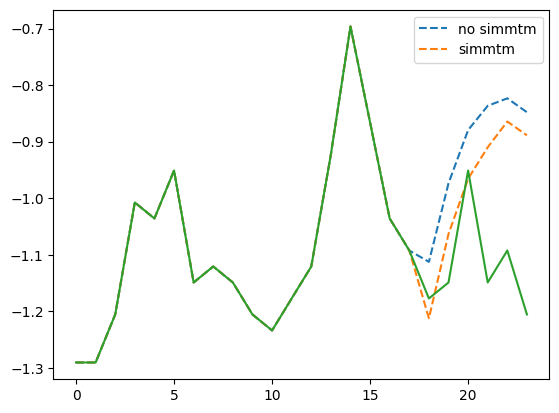

In [29]:
i = 4
j = 1
plt.plot(
    torch.cat((X[i, :, j], pred_1[i, :, j])).cpu().detach().numpy(),
    ls="--",
    label="no simmtm",
)
plt.plot(
    torch.cat((X[i, :, j], pred_2[i, :, j])).cpu().detach().numpy(),
    ls="--",
    label="simmtm",
)
plt.plot(torch.cat((X[i, :, j], target[i, :, j])).cpu().detach().numpy())
plt.legend()

Reference:
1. https://arxiv.org/abs/2302.00861
2. https://github.com/gzerveas/mvts_transformer

Normalized Results

No Pretrain

Test MSE loss: 0.401656836271286

Test MSE loss: 0.3942021131515503

Test MSE loss: 0.4026849865913391

Test MSE loss: 0.3934531509876251

Test MSE loss: 0.4011250138282776

Pretrain

Test MSE loss: 0.39376363158226013

Test MSE loss: 0.3938564658164978

Test MSE loss: 0.39758536219596863

Test MSE loss: 0.3879236876964569

Test MSE loss: 0.3867727518081665

Unnormalized Results

No Pretrain

Test MSE loss: 28955.188077749768

Test MSE loss: 26232.348384247733

Test MSE loss: 29180.849135569904

Test MSE loss: 25597.15184640446

Test MSE loss: 28796.784927283206

Pretrain

Test MSE loss: 25913.2302627422

Test MSE loss: 26665.712613352596

Test MSE loss: 26484.948554457686

Test MSE loss: 26331.686181724996

Test MSE loss: 25527.132474246446